# 1 Data wrangling<a id='2_Data_wrangling'></a>

The purpose of this data science project is to develop a model to anticipate what inflation in the United States will be measured as the Consumer Price Index for All Urban Consumers in the United States ( “Inflation” ). Inflation is an important component of developing investment strategies for portfolios across the world. The view on inflation being positive or negative is not agreed upon nor are the variables which influence it.

In this project, I have shortlisted <font color=red>**eighteen**</font> ( <font color=red>**18**</font> ) <font color=red>**variables**</font> to determine their influence on inflation.

The fundamental <font color=red>**questions to resolve in this notebook**</font> before we move on are:
   * Are the identified variables correlated with inflation?
   * Is there enough data to build out a model?


## 1.1 Imports & Others <a id='2.3_Imports'></a>

In [646]:
#Import the necessary tools required in the correct lines below
import quandl
from fredapi import Fred
from getpass import getpass
import investpy


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import os
import lxml
import datetime
import requests
import json
import collections
import seaborn as sns
from scipy import stats
import numpy as np


In [647]:
# These will be needed later

now = datetime.datetime.now()
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")
today_y_m_d_dash = now.strftime("%Y-%m-%d")
today_d_m_y_dash = now.strftime("%d/%m/%Y")


In [648]:
# Importing Quandl API requires a password
# If you don't have one, please see the link below
# https://docs.quandl.com/docs#section-authentication

my_quandl_API = getpass()

········


In [649]:
quandl.ApiConfig.api_key = my_quandl_API

In [650]:
# Importing FRED API requires a password ( FRED stands for Federal Reserve Economic Data )
# If you don't have one, please see the link below
# https://fred.stlouisfed.org/docs/api/fred/

my_FRED_API = getpass()

········


In [651]:
fred = Fred(api_key=my_FRED_API)

In [652]:
# Here I am structuring a color scale for heatmaps which will be used later

cdict = {'green':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'red': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Create the colormap using the dictionary
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)


## 1.2 Loaded Data<a id='2.5_Load_The_Ski_Resort_Data'></a>

Please note, I may intend to build another USD Index based on the United States actual engagement in the world.
In other words, the USD Index used ( as of now ), is not based on the United States' trade with the world
I listed below FX pairs to possibly build out a "version" of The [USD Index Trade Weighted](https://en.wikipedia.org/wiki/Trade-weighted_US_dollar_index) but given time constraints I will work with the US Dollar Index ( not trade weighted ) for now.

While the Trade Weighted Index can be accessed by an API ( FRED ), it only goes back to 2006 
so something similar would need be created if time permits. 
My major hurdle at this time is accessing trade data & time.

   * Eurozone, Canada, Japan, Mexico, China, United Kingdom, Taiwan, South Korea, Singapore, Hong Kong, Malaysia, Brazil, Switzerland, Thailand, Philippines, Australia, Indonesia, India, Israel, Saudi Arabia, Russia, Sweden, Argentina, Venezuela, Chile & Colombia


In [653]:
# Daily Data
usd_index = quandl.get('CHRIS/ICE_DX1')
wti = quandl.get('CHRIS/CME_CL1')
copper = investpy.get_commodity_historical_data(commodity='Copper', country='United States', from_date='01/01/1978', to_date=today_d_m_y_dash)
soybeans = investpy.get_commodity_historical_data(commodity='US Soybeans', from_date='01/01/1978', to_date=today_d_m_y_dash)
natgas = investpy.get_commodity_historical_data(commodity='Natural Gas', from_date='01/01/1978', to_date=today_d_m_y_dash)
heatoil = investpy.get_commodity_historical_data(commodity='Heating Oil', from_date='01/01/1978', to_date=today_d_m_y_dash)
corn = investpy.get_commodity_historical_data(commodity='US Corn', from_date='01/01/1978', to_date=today_d_m_y_dash)
wheat = investpy.get_commodity_historical_data(commodity='US Wheat', from_date='01/01/1978', to_date=today_d_m_y_dash)
cattle = investpy.get_commodity_historical_data(commodity='Live Cattle', from_date='01/01/1978', to_date=today_d_m_y_dash)
sugar = investpy.get_commodity_historical_data(commodity='US Sugar #11', from_date='01/01/1978', to_date=today_d_m_y_dash)
lumber = investpy.get_commodity_historical_data(commodity='Lumber', from_date='01/01/1978', to_date=today_d_m_y_dash)
leanhogs = investpy.get_commodity_historical_data(commodity='Lean Hogs', from_date='01/01/1978', to_date=today_d_m_y_dash)

# Weekly Data
int_job_claims = quandl.get('FRED/ICSA')    # Hasn't been factored in yet

# Monthly Data
cpi = quandl.get('RATEINF/INFLATION_USA')
wages_cpi = fred.get_series('CWSR0000SA0')
cap_util = fred.get_series('TCU')
unrate = quandl.get('FRED/UNRATE')          # Hasn't been factored in yet


# Quarterly Data
m2_velo = fred.get_series('M2V')
gdp = fred.get_series('GDP')


In [654]:
# I chose not to not include the below for the reasons listed above their code:

# This may have altered the heatmap w/ M2 Velocity; this was less correlated   
    # us_M2 = fred.get_series('M2')              
# only goes back to 2005
    # steel = investpy.get_commodity_historical_data(commodity='US Midwest Domestic Hot-Rolled Coil Steel Futures', from_date='01/01/1978', to_date=today_d_m_y_dash)
# only goes back to 2005
    # gasoline = investpy.get_commodity_historical_data(commodity='Gasoline RBOB', from_date='01/01/1978', to_date=today_d_m_y_dash)
# only goes back to 2008  
    # oats = investpy.get_commodity_historical_data(commodity='Oats', from_date='01/01/1978', to_date=today_d_m_y_dash)
# this was removed due to amount of data
    # us_wages_hrly_earnings = fred.get_series('CES0500000003')
# poor results
    # us_wages_compensation = fred.get_series('A576RC1')
# only goes back ~2016
    # steel = investpy.get_commodity_historical_data(commodity='US Midwest Domestic Hot-Rolled Coil Steel', from_date='01/01/1978', to_date=today_d_m_y_dash)


In [662]:
# As the purpose of this section is to accumulate all the data into one location to cross reference future works integrity,
# I put all here to referance ( if required ) later.

main_df = pd.concat([cpi,gdp,m2_velo,wages_cpi,wti['Last'],heatoil['Close'],copper['Close'],sugar['Close'],natgas['Close'],
                     cattle['Close'],leanhogs['Close'],soybeans['Close'],lumber['Close'],
                     cap_util,corn['Close'],gdp,m2_velo,wheat['Close'],usd_index['Settle'],unrate,int_job_claims],
                    axis = 1, ignore_index=False)

main_df = main_df.fillna(method='ffill')
main_df.columns = ['Inflation','Wages CPI','WTI','Heating Oil','Copper','Sugar','Natural Gas','Cattle',
                   'Lean Hogs','Soybeans','Lumber','Capacity Utilization','Corn','GDP','M2 Velocity','GDP',
                   'M2 Velocity','Wheat','USD Index','Unemployment Rate','Initial Jobless Claims'
                  ]
main_df['Inflation'].index
main_df.index.names = ["Date"]

main_df = main_df[main_df.index.dayofweek < 5]

main_df.sort_values(by="Date", ascending=False)

# I will sometimes take a look to ensure it is working properly
# main_df.tail()
# main_df.head()


,Inflation,Wages CPI,WTI,Heating Oil,Copper,Sugar,Natural Gas,Cattle,Lean Hogs,Soybeans,...,Capacity Utilization,Corn,GDP,M2 Velocity,GDP,M2 Velocity,Wheat,USD Index,Unemployment Rate,Initial Jobless Claims
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-24,1.40,21479.529,1.129,256.044,61.20,1.8998,4.3193,17.20,2.805,122.188,...,1425.62,1011.9,75.5501,556.62,21479.529,1.129,682.00,90.167,6.3,861000.0
2021-02-23,1.40,21479.529,1.129,256.044,61.20,1.8680,4.1875,18.41,2.879,115.625,...,1408.00,1018.1,75.5501,553.75,21479.529,1.129,672.25,90.167,6.3,861000.0
2021-02-22,1.40,21479.529,1.129,256.044,61.66,1.8586,4.1490,18.78,2.953,115.725,...,1386.25,1021.8,75.5501,551.00,21479.529,1.129,673.50,89.999,6.3,861000.0
2021-02-19,1.40,21479.529,1.129,256.044,58.99,1.8229,4.0775,17.79,3.069,115.925,...,1378.38,990.3,75.5501,542.75,21479.529,1.129,653.12,90.363,6.3,861000.0
2021-02-18,1.40,21479.529,1.129,256.044,60.27,1.8364,3.9070,17.51,3.082,115.125,...,1374.25,1004.5,75.5501,550.25,21479.529,1.129,664.50,90.600,6.3,861000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914-08-31,3.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-07-31,1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-06-30,1.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [663]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11447 entries, 1914-03-31 to 2021-02-24
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               11447 non-null  float64
 1   Wages CPI               11161 non-null  float64
 2   WTI                     10955 non-null  float64
 3   Heating Oil             11161 non-null  float64
 4   Copper                  9769 non-null   float64
 5   Sugar                   10596 non-null  float64
 6   Natural Gas             8412 non-null   float64
 7   Cattle                  10596 non-null  float64
 8   Lean Hogs               7979 non-null   float64
 9   Soybeans                10591 non-null  float64
 10  Lumber                  10596 non-null  float64
 11  Capacity Utilization    8045 non-null   float64
 12  Corn                    10596 non-null  float64
 13  GDP                     10817 non-null  float64
 14  M2 Velocity          

`Inflation` has by and large the most data while `Natural Gas` has the least. Let's move forward with using the `USD` amount limitations.

I will move forward with only the data where all information is present with no null values

In [664]:
main_df = main_df.loc['1990-04-04':today_y_m_d_dash]

# The reason 1990 was chosen is becuase Natural Gas only goes back that far; take a look if you wish 
# natgas.head()

In [665]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7979 entries, 1990-04-04 to 2021-02-24
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               7979 non-null   float64
 1   Wages CPI               7979 non-null   float64
 2   WTI                     7979 non-null   float64
 3   Heating Oil             7979 non-null   float64
 4   Copper                  7979 non-null   float64
 5   Sugar                   7979 non-null   float64
 6   Natural Gas             7979 non-null   float64
 7   Cattle                  7979 non-null   float64
 8   Lean Hogs               7979 non-null   float64
 9   Soybeans                7979 non-null   float64
 10  Lumber                  7979 non-null   float64
 11  Capacity Utilization    7979 non-null   float64
 12  Corn                    7979 non-null   float64
 13  GDP                     7979 non-null   float64
 14  M2 Velocity           

In [666]:
# Here I am saving the non-adjusted ( raw ) data to investigate whether the adjustments further along yield correctly

main_df = main_df.sort_values(by="Date", ascending=False)

main_df_csv = pd.DataFrame(main_df)
main_df_csv.to_excel('./_Capstone_One_Inflation/data/main_df_csv_w_commodities.xlsx')
print('Finished; keep going!')

Finished; keep going!


# 1.3.1 Q on Q Comparison

In 1.3.1 I will be setting up the infrastructure for **comparing quarterly changes on all variables** against a **quarterly change in inflation** to ascertain if there's any correlation & if so by which variables are more pronounced. 

In [667]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index = usd_index['Settle'].pct_change(periods=66)
Q_wti = wti['Last'].pct_change(periods=66)

Q_copper = copper['Close'].pct_change(periods=66)
Q_soybeans = soybeans['Close'].pct_change(periods=66)
Q_natgas = natgas['Close'].pct_change(periods=66)
Q_heatoil = heatoil['Close'].pct_change(periods=66)
Q_corn = corn['Close'].pct_change(periods=66)
Q_wheat = wheat['Close'].pct_change(periods=66)
Q_cattle = cattle['Close'].pct_change(periods=66)
Q_sugar = sugar['Close'].pct_change(periods=66)
Q_lumber = lumber['Close'].pct_change(periods=66)
Q_leanhogs = leanhogs['Close'].pct_change(periods=66)

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs = int_job_claims.diff(periods=12)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil = cap_util.pct_change(periods=3)
Q_wages = wages_cpi.pct_change(periods=3)
Q_cpi = cpi.diff(periods=3)
Q_unrate = unrate.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)


In [668]:
# ( Complete ) The above were slow reviewed & they all align with the forward fill modus operandi 

QonQ_vars = pd.concat([Q_wages,Q_wti,Q_heatoil,Q_copper,Q_sugar,
                     Q_natgas,Q_cattle,Q_leanhogs,Q_soybeans,Q_lumber,
                     Q_caputil,Q_corn,Q_gdp,Q_m2_velo,Q_wheat,
                      Q_usd_index,Q_intjobs,Q_unrate],
                      axis = 1, ignore_index=False)

QonQ_vars = QonQ_vars.fillna(method='ffill')
QonQ_vars.columns = ['Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','GDP','M2 Velocity','Wheat',
                     'USD Index','Initial Jobless Claims','Unemployment Rate']

QonQ_vars.dropna(how='any')
QonQ_vars.index.names = ["Date"]

QonQ_vars = QonQ_vars[QonQ_vars.index.dayofweek < 5]

QonQ_vars = QonQ_vars.sort_values(by="Date", ascending=True)

In [669]:
# Determining the null values
QonQ_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10878 entries, 1946-01-01 to 2021-02-24
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                10873 non-null  float64
 1   WTI                     9699 non-null   float64
 2   Heating Oil             10524 non-null  float64
 3   Copper                  8343 non-null   float64
 4   Sugar                   10524 non-null  float64
 5   Natural Gas             7907 non-null   float64
 6   Cattle                  10521 non-null  float64
 7   Lean Hogs               10525 non-null  float64
 8   Soybeans                7976 non-null   float64
 9   Lumber                  10525 non-null  float64
 10  Capacity Utilization    10700 non-null  float64
 11  Corn                    10523 non-null  float64
 12  GDP                     10873 non-null  float64
 13  M2 Velocity             10771 non-null  float64
 14  Wheat                

In [670]:
# As previously mentioned, Natural Gas limits this Dataframe
# Thus, the reason 1990-07-10 was chosen is becuase Natural Gas only goes back that far 

QonQ_vars = QonQ_vars.loc['1990-07-10':today_y_m_d_dash]

In [671]:
# Double confirming no null values
QonQ_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7907 entries, 1990-07-10 to 2021-02-24
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                7907 non-null   float64
 1   WTI                     7907 non-null   float64
 2   Heating Oil             7907 non-null   float64
 3   Copper                  7907 non-null   float64
 4   Sugar                   7907 non-null   float64
 5   Natural Gas             7907 non-null   float64
 6   Cattle                  7907 non-null   float64
 7   Lean Hogs               7907 non-null   float64
 8   Soybeans                7907 non-null   float64
 9   Lumber                  7907 non-null   float64
 10  Capacity Utilization    7907 non-null   float64
 11  Corn                    7907 non-null   float64
 12  GDP                     7907 non-null   float64
 13  M2 Velocity             7907 non-null   float64
 14  Wheat                 

Saving the Variables for later use to confirm rolling averages.

In [672]:
QonQ_vars = QonQ_vars.sort_values(by="Date", ascending=False)
QonQ_vars_csv = pd.DataFrame(QonQ_vars)

QonQ_vars_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_vars.xlsx')
print('Finished; keep going!')

Finished; keep going!


Now that the variables are in place, I will pull `Inflation` in with them via a merge to ensure the variables are working off the `Inflation` set. 

In [673]:
QonQ_main = Q_cpi.merge(QonQ_vars, how='left', on='Date')

# QonQ_forward.loc[:,cols_forward] = QonQ.loc[:,cols_forward].ffill()
QonQ_main.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper',
                'Sugar','Natural Gas','Cattle','Lean Hogs','Soybeans',
                'Lumber','Capacity Utilization','Corn','GDP','M2 Velocity',
                'Wheat','USD Index','Initial Jobless Claims','Unemployment Rate']

QonQ_main = QonQ_main.dropna()

In [674]:
QonQ_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259 entries, 1990-07-31 to 2020-12-31
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               259 non-null    float64
 1   Wage CPI                259 non-null    float64
 2   WTI                     259 non-null    float64
 3   Heating Oil             259 non-null    float64
 4   Copper                  259 non-null    float64
 5   Sugar                   259 non-null    float64
 6   Natural Gas             259 non-null    float64
 7   Cattle                  259 non-null    float64
 8   Lean Hogs               259 non-null    float64
 9   Soybeans                259 non-null    float64
 10  Lumber                  259 non-null    float64
 11  Capacity Utilization    259 non-null    float64
 12  Corn                    259 non-null    float64
 13  GDP                     259 non-null    float64
 14  M2 Velocity            

# 1.3.1.2 Cleaning the Q on Q Dataframe for outliers 

Here I begin to determine where outliers are:

In [675]:
QonQ_main.corr(method='pearson')

,Inflation,Wage CPI,WTI,Heating Oil,Copper,Sugar,Natural Gas,Cattle,Lean Hogs,Soybeans,Lumber,Capacity Utilization,Corn,GDP,M2 Velocity,Wheat,USD Index,Initial Jobless Claims,Unemployment Rate
Inflation,1.000000,0.717374,0.347553,0.425767,0.221556,0.151809,0.298157,0.165345,0.177281,0.058990,0.127012,0.284801,0.075774,0.268401,0.255618,-0.037458,-0.220835,-0.089727,-0.250500
Wage CPI,0.717374,1.000000,0.410007,0.501180,0.326784,0.188646,0.306310,0.201202,0.114211,0.134259,0.099173,0.240888,0.068514,0.285254,0.305391,-0.003795,-0.295176,-0.086933,-0.229621
WTI,0.347553,0.410007,1.000000,0.801081,0.427700,0.180981,0.250464,0.155744,0.125411,0.151827,0.279960,0.423042,0.034765,0.292133,0.176767,-0.013760,-0.270599,-0.429905,-0.259232
Heating Oil,0.425767,0.501180,0.801081,1.000000,0.417235,0.168726,0.412958,0.151078,0.087197,0.169757,0.137156,0.369393,0.049336,0.249292,0.232261,0.000361,-0.309808,-0.275829,-0.250005
Copper,0.221556,0.326784,0.427700,0.417235,1.000000,0.255090,0.087862,0.120683,0.146652,0.207905,0.207631,0.247462,0.107980,0.153601,0.136818,0.082159,-0.351754,-0.171519,-0.092123
Sugar,0.151809,0.188646,0.180981,0.168726,0.255090,1.000000,0.150063,0.028733,-0.086056,0.136992,0.087038,0.183948,0.078851,0.127853,0.107109,0.086394,-0.140455,-0.128357,-0.119909
Natural Gas,0.298157,0.306310,0.250464,0.412958,0.087862,0.150063,1.000000,0.015283,0.024183,0.058428,-0.068966,0.128484,0.075419,0.101987,0.086603,0.011773,-0.240528,-0.051962,-0.064724
Cattle,0.165345,0.201202,0.155744,0.151078,0.120683,0.028733,0.015283,1.000000,0.176569,0.088762,0.195019,0.315213,0.031467,0.248495,0.204197,0.012129,-0.049553,-0.175781,-0.285768
Lean Hogs,0.177281,0.114211,0.125411,0.087197,0.146652,-0.086056,0.024183,0.176569,1.000000,0.206747,0.166738,0.154603,0.235256,0.159614,0.121125,0.033494,0.039408,-0.048307,-0.127586
Soybeans,0.058990,0.134259,0.151827,0.169757,0.207905,0.136992,0.058428,0.088762,0.206747,1.000000,0.197829,0.141625,0.707152,0.053850,0.037669,0.434461,-0.143919,-0.051853,-0.066285


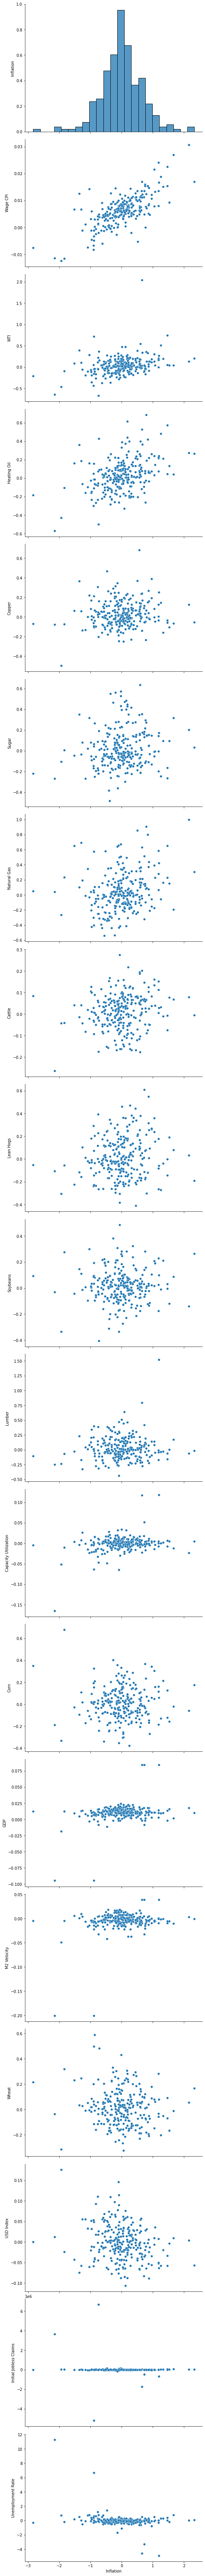

In [812]:
sns.pairplot(QonQ_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper',
                'Sugar','Natural Gas','Cattle','Lean Hogs','Soybeans',
                'Lumber','Capacity Utilization','Corn','GDP','M2 Velocity',
                'Wheat','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

We can see a **notable amount of variation** in `Inflation` on all variables. We will take a look at how this comes out on a histogram.

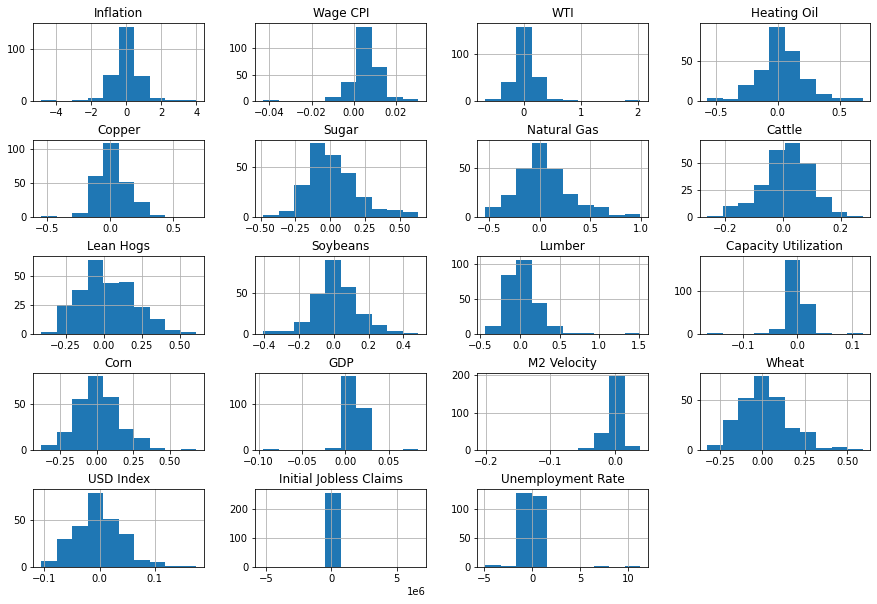

In [677]:
QonQ_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

Text(0, 0.5, 'Count')

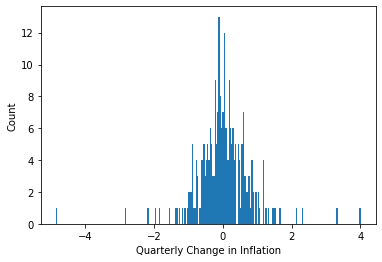

In [678]:
plt.hist(QonQ_main['Inflation'], bins=240)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

It may appear that we scrape anything ± 300 bps

In [679]:
cpi_comp = np.abs(stats.zscore(QonQ_main['Inflation']))
threshold = 3
print(np.where( cpi_comp > threshold ))

(array([137, 156, 163, 164], dtype=int64),)


In [680]:
QonQ_main['Inflation'][137], QonQ_main['Inflation'][156], QonQ_main['Inflation'][163],QonQ_main['Inflation'][164]

(-2.84, -4.846, 3.322, 4.007)

We will pull ~3 off ( -4.846, 3.322, 4.007 )

In [681]:
droprows = [156, 163, 164]
QonQ_main.drop(QonQ_main.index[droprows], inplace=True)

Text(0, 0.5, 'Count')

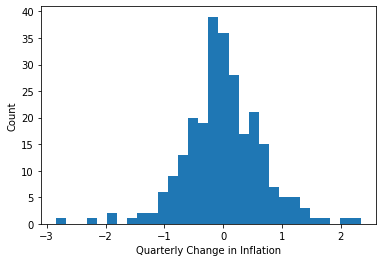

In [682]:
plt.hist(QonQ_main['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

After removing the outliers of Inflation, let's see how the pair plots & histograms hold up.

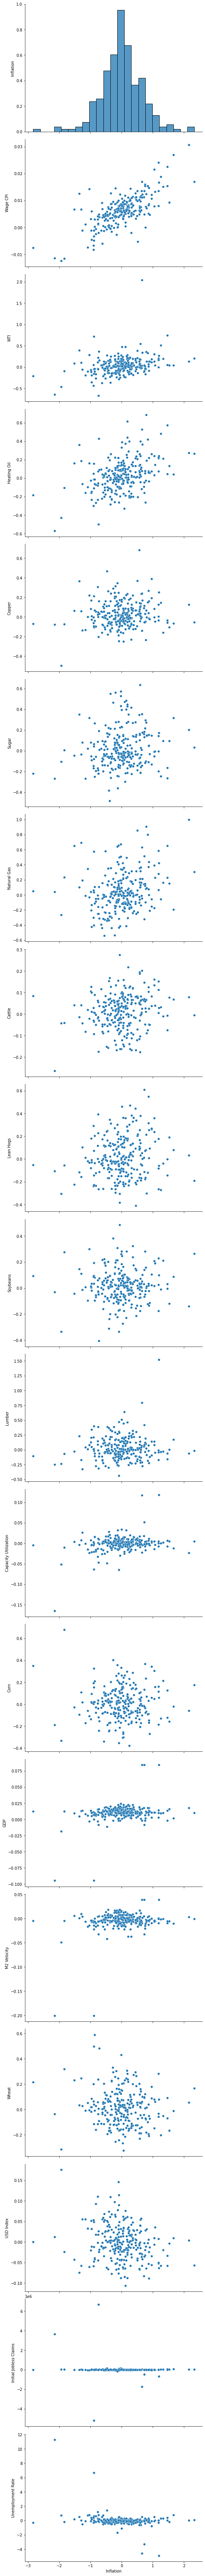

In [683]:
sns.pairplot(QonQ_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper',
                'Sugar','Natural Gas','Cattle','Lean Hogs','Soybeans',
                'Lumber','Capacity Utilization','Corn','GDP','M2 Velocity',
                'Wheat','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

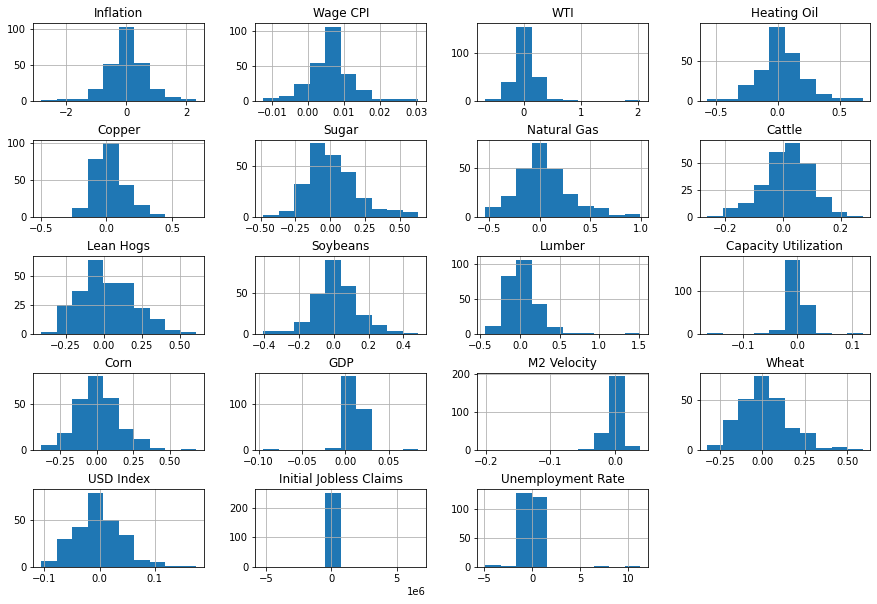

In [684]:
QonQ_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

In [685]:
QonQ_main['WTI'].max()

2.046721929163527

In [686]:
QonQ_main['WTI'].tail()

Date
2020-07-31    2.046722
2020-08-31    0.272511
2020-09-30    0.044549
2020-11-30    0.038010
2020-12-31    0.193493
Name: WTI, dtype: float64

In [687]:
QonQ_main.corr(method='pearson')

,Inflation,Wage CPI,WTI,Heating Oil,Copper,Sugar,Natural Gas,Cattle,Lean Hogs,Soybeans,Lumber,Capacity Utilization,Corn,GDP,M2 Velocity,Wheat,USD Index,Initial Jobless Claims,Unemployment Rate
Inflation,1.000000,0.714682,0.324981,0.406480,0.107570,0.139928,0.247702,0.150359,0.142394,0.012778,0.067501,0.258689,-0.014446,0.253571,0.220986,-0.117855,-0.214744,-0.100083,-0.276595
Wage CPI,0.714682,1.000000,0.377934,0.472546,0.237934,0.191947,0.308960,0.159910,0.099349,0.103869,0.069887,0.213317,0.012955,0.253523,0.273839,-0.034058,-0.288687,-0.095907,-0.221950
WTI,0.324981,0.377934,1.000000,0.793927,0.400628,0.174583,0.240542,0.136934,0.114789,0.136876,0.270985,0.411569,0.013231,0.275108,0.155163,-0.025017,-0.261291,-0.435650,-0.251519
Heating Oil,0.406480,0.472546,0.793927,1.000000,0.384046,0.161312,0.407202,0.129879,0.073705,0.153364,0.122213,0.354898,0.024631,0.228888,0.209355,-0.012730,-0.300599,-0.280212,-0.241714
Copper,0.107570,0.237934,0.400628,0.384046,1.000000,0.249165,0.059101,0.092240,0.129564,0.187984,0.189932,0.223400,0.076253,0.122908,0.101570,0.066629,-0.344100,-0.176179,-0.077065
Sugar,0.139928,0.191947,0.174583,0.161312,0.249165,1.000000,0.143432,0.024100,-0.095045,0.130424,0.081588,0.178511,0.073707,0.122946,0.100462,0.083316,-0.139281,-0.128047,-0.118034
Natural Gas,0.247702,0.308960,0.240542,0.407202,0.059101,0.143432,1.000000,0.010920,0.004756,0.050178,-0.097417,0.110471,0.046288,0.091420,0.069701,-0.012816,-0.233035,-0.050363,-0.064346
Cattle,0.150359,0.159910,0.136934,0.129879,0.092240,0.024100,0.010920,1.000000,0.174316,0.077689,0.192366,0.308097,0.021372,0.235579,0.191067,0.009914,-0.040253,-0.177138,-0.278617
Lean Hogs,0.142394,0.099349,0.114789,0.073705,0.129564,-0.095045,0.004756,0.174316,1.000000,0.199947,0.155906,0.144237,0.225687,0.153102,0.110861,0.022969,0.045578,-0.047235,-0.126438
Soybeans,0.012778,0.103869,0.136876,0.153364,0.187984,0.130424,0.050178,0.077689,0.199947,1.000000,0.193508,0.132062,0.714506,0.041732,0.024095,0.437927,-0.140317,-0.051511,-0.059977


{'whiskers': [<matplotlib.lines.Line2D at 0x2b62f1dbd30>,
 'caps': [<matplotlib.lines.Line2D at 0x2b62f1f23d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b62f1dbb80>],
 'medians': [<matplotlib.lines.Line2D at 0x2b62f1f2a30>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b62f1f2d60>],
 'means': []}

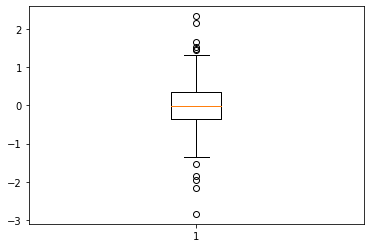

In [688]:
plt.boxplot(QonQ_main['Inflation'])

Text(0.5, 1.0, 'Quarter on Quarter Comparison')

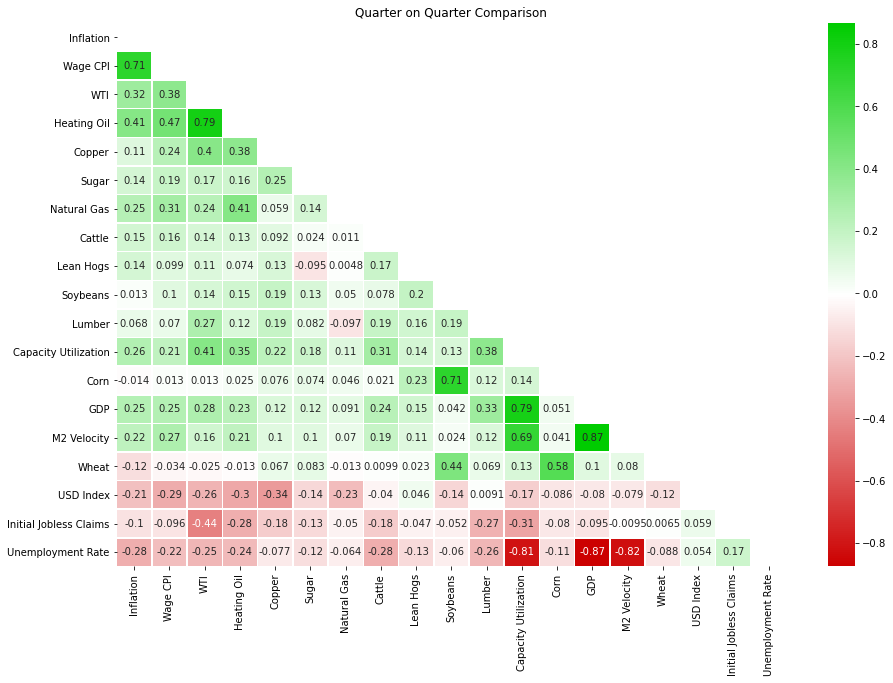

In [689]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main.corr())
sns.heatmap(QonQ_main.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison')

In [690]:
QonQ_main = QonQ_main.sort_values(by="Date", ascending=True)
QonQ_main_csv = pd.DataFrame(QonQ_main)

QonQ_main_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_main.xlsx')
print('Finished')

Finished


# 1.3.2 Monthly Changes<a id='2.5_Load_The_Ski_Resort_Data'></a>

In 1.3.2 I will be setting up the infrastructure for **comparing monthly changes on all variables** against a **monthly change in inflation** to ascertain if there's any correlation & if so by which variables are more pronounced. 

In [691]:
# ( Complete ) Daily | USD & WTI 
M_usd_index = usd_index['Settle'].pct_change(periods=30)
M_wti = wti['Last'].pct_change(periods=30)
M_copper = copper['Close'].pct_change(periods=30)
M_soybeans = soybeans['Close'].pct_change(periods=30)
M_natgas = natgas['Close'].pct_change(periods=30)
M_heatoil = heatoil['Close'].pct_change(periods=30)
M_corn = corn['Close'].pct_change(periods=30)
M_wheat = wheat['Close'].pct_change(periods=30)
M_cattle = cattle['Close'].pct_change(periods=30)
M_sugar = sugar['Close'].pct_change(periods=30)
M_lumber = lumber['Close'].pct_change(periods=30)
M_leanhogs = leanhogs['Close'].pct_change(periods=30)

# ( Complete ) Weekly | Initial Jobless Claims
M_intjobs = int_job_claims.diff(periods=4)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
M_caputil = cap_util.pct_change(periods=1)
M_wages = wages_cpi.pct_change(periods=1)
M_cpi = cpi.diff(periods=1)
M_unrate = unrate.diff(periods=1)


# ( Complete ) Quarterly | GDP, Velocity of Money
# M_gdp = us_gdp.pct_change(periods=1)
# M_m2_velo = m2_velo.pct_change(periods=1)

In [745]:
# Building out the variables first with a forward fill
MonM_vars = pd.concat([M_wages,M_wti,M_copper,M_soybeans,M_natgas,
                       M_heatoil,M_corn,M_wheat,M_cattle,M_leanhogs,M_sugar,
                       M_lumber,M_caputil,M_usd_index,M_intjobs,M_unrate
                      ],
                      axis = 1, ignore_index=False)

MonM_vars.columns= ['Wage CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','USD Index','Initial Jobless Claims','Unemployment Rate'
                   ]

MonM_vars.index.names = ["Date"]
MonM_vars = MonM_vars.fillna(method='ffill')

# vars_mnth.tail()

In [746]:
MonM_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14109 entries, 1947-01-01 to 2021-02-24
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                14108 non-null  float64
 1   WTI                     12021 non-null  float64
 2   Copper                  10376 non-null  float64
 3   Soybeans                9933 non-null   float64
 4   Natural Gas             9852 non-null   float64
 5   Heating Oil             13021 non-null  float64
 6   Corn                    13020 non-null  float64
 7   Wheat                   9933 non-null   float64
 8   Cattle                  13018 non-null  float64
 9   Lean Hogs               13023 non-null  float64
 10  Sugar                   13023 non-null  float64
 11  Lumber                  13023 non-null  float64
 12  Capacity Utilization    13864 non-null  float64
 13  USD Index               11205 non-null  float64
 14  Initial Jobless Claim

In [747]:
# As before, working backwards off of Natural Gas to bring the data together
# MonM_vars['Natural Gas'].tail(8302)

MonM_vars = MonM_vars.loc['1990-05-17':today_y_m_d_dash]

In [748]:
MonM_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9852 entries, 1990-05-17 to 2021-02-24
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                9852 non-null   float64
 1   WTI                     9852 non-null   float64
 2   Copper                  9852 non-null   float64
 3   Soybeans                9852 non-null   float64
 4   Natural Gas             9852 non-null   float64
 5   Heating Oil             9852 non-null   float64
 6   Corn                    9852 non-null   float64
 7   Wheat                   9852 non-null   float64
 8   Cattle                  9852 non-null   float64
 9   Lean Hogs               9852 non-null   float64
 10  Sugar                   9852 non-null   float64
 11  Lumber                  9852 non-null   float64
 12  Capacity Utilization    9852 non-null   float64
 13  USD Index               9852 non-null   float64
 14  Initial Jobless Claims

In [751]:
# Putting them together with inflation
MonM_main = M_cpi.merge(MonM_vars, how='left', on='Date')

MonM_main = MonM_main[MonM_main.index.dayofweek < 5]

MonM_main.columns = ['Inflation','Wage CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','USD Index','Initial Jobless Claims','Unemployment Rate'
                    ]

MonM_main = MonM_main.dropna()

In [752]:
MonM_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 1990-05-31 to 2020-12-31
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               260 non-null    float64
 1   Wage CPI                260 non-null    float64
 2   WTI                     260 non-null    float64
 3   Copper                  260 non-null    float64
 4   Soybeans                260 non-null    float64
 5   Natural Gas             260 non-null    float64
 6   Heating Oil             260 non-null    float64
 7   Corn                    260 non-null    float64
 8   Wheat                   260 non-null    float64
 9   Cattle                  260 non-null    float64
 10  Lean Hogs               260 non-null    float64
 11  Sugar                   260 non-null    float64
 12  Lumber                  260 non-null    float64
 13  Capacity Utilization    260 non-null    float64
 14  USD Index              

# 1.3.2.2 Cleaning the M on M Dataframe for outliers 

Here I begin to determine where outliers are:

In [753]:
MonM_main.corr(method='pearson')

,Inflation,Wage CPI,WTI,Copper,Soybeans,Natural Gas,Heating Oil,Corn,Wheat,Cattle,Lean Hogs,Sugar,Lumber,Capacity Utilization,USD Index,Initial Jobless Claims,Unemployment Rate
Inflation,1.000000,0.709537,0.292187,0.117664,0.080194,0.137183,0.307840,0.054724,-0.049427,0.024347,0.048417,0.147915,0.186274,0.248983,-0.112935,-0.044121,-0.190105
Wage CPI,0.709537,1.000000,0.364418,0.206845,0.081559,0.152236,0.386575,-0.001987,-0.012168,0.079468,0.003978,0.141510,0.151202,0.229097,-0.172862,-0.021465,-0.172400
WTI,0.292187,0.364418,1.000000,0.384297,0.123567,0.230212,0.827887,0.050932,-0.036583,0.085183,0.066520,0.111835,0.160139,0.205434,-0.267559,-0.259514,-0.064489
Copper,0.117664,0.206845,0.384297,1.000000,0.243327,0.009313,0.342839,0.101879,0.057647,0.127847,0.151706,0.199234,0.194249,0.092737,-0.269324,-0.135772,0.017929
Soybeans,0.080194,0.081559,0.123567,0.243327,1.000000,0.050035,0.139177,0.670592,0.424675,0.091984,0.163542,0.158368,0.153085,0.076851,-0.145117,0.004533,-0.049397
Natural Gas,0.137183,0.152236,0.230212,0.009313,0.050035,1.000000,0.317274,0.068578,0.024085,-0.054093,0.058867,0.082055,-0.054959,-0.005891,-0.140661,-0.083945,-0.060604
Heating Oil,0.307840,0.386575,0.827887,0.342839,0.139177,0.317274,1.000000,0.061041,0.022313,0.077321,0.022929,0.103574,0.094411,0.220972,-0.188047,-0.144416,-0.096859
Corn,0.054724,-0.001987,0.050932,0.101879,0.670592,0.068578,0.061041,1.000000,0.564109,-0.032945,0.130425,0.100097,0.085051,0.099385,-0.096376,-0.027489,-0.101096
Wheat,-0.049427,-0.012168,-0.036583,0.057647,0.424675,0.024085,0.022313,0.564109,1.000000,0.034200,0.032638,0.098145,0.062945,0.063741,-0.065288,0.056499,-0.107989
Cattle,0.024347,0.079468,0.085183,0.127847,0.091984,-0.054093,0.077321,-0.032945,0.034200,1.000000,0.180542,0.077874,0.143381,0.115595,-0.021208,-0.132475,-0.124310


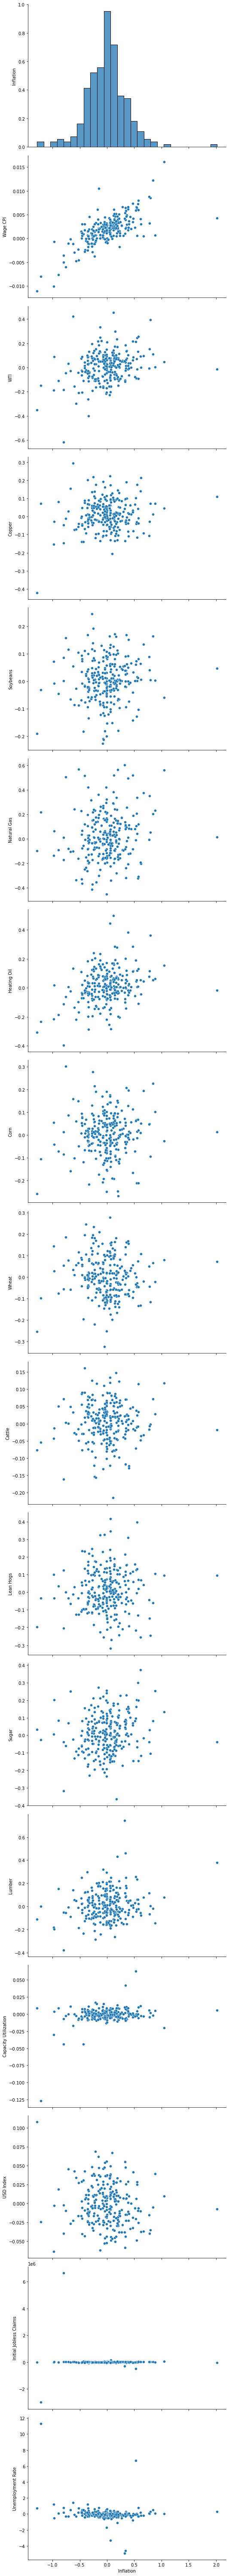

In [754]:
sns.pairplot(MonM_main,
            y_vars=['Inflation','Wage CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

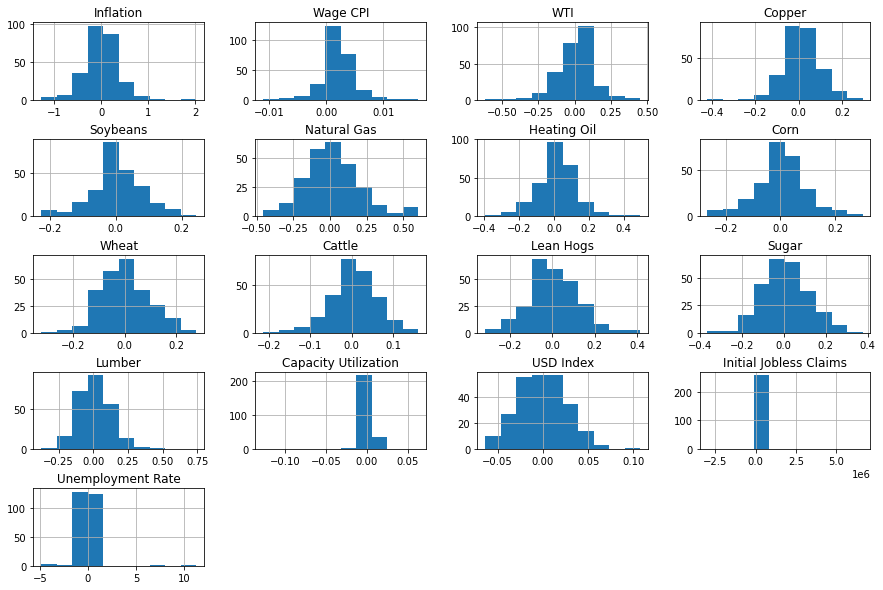

In [755]:
MonM_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

We see **"some" amount of variation** in `Inflation` on all variables. We will take a look at how this comes out on a histogram again.

Text(0, 0.5, 'Count')

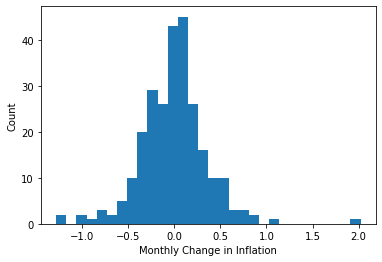

In [756]:
plt.hist(MonM_main['Inflation'], bins=30)
plt.xlabel('Monthly Change in Inflation')
plt.ylabel('Count')

**There doesn't seem to be as much variation here as well.** Let's take a look at what those numbers are.

In [757]:
print('Min # is:', MonM_main['Inflation'].min(), 'Max # is:', MonM_main['Inflation'].max())

Min # is: -1.2820000000000005 Max # is: 2.021


Based on this, I will choose to remove the data point ~2

In [758]:
cpi_check = np.abs(stats.zscore(MonM_main['Inflation']))
threshold = 3
print(np.where(cpi_check > threshold))

(array([156, 164, 253], dtype=int64),)


In [759]:
MonM_main['Inflation'][156],MonM_main['Inflation'][164],MonM_main['Inflation'][253]

(-1.2820000000000005, 2.021, -1.21)

In [760]:
droprow = [164]
MonM_main.drop(MonM_main.index[droprow], inplace=True)

Checking the pair plots & histogram once more.

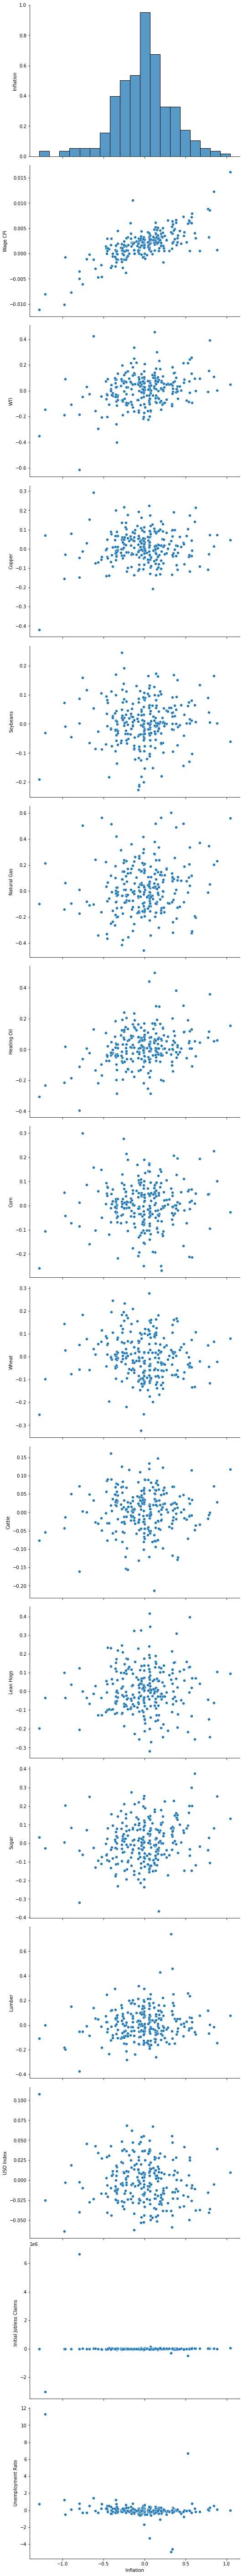

In [761]:
sns.pairplot(MonM_main,
            y_vars=['Inflation','Wage CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

Text(0, 0.5, 'Probability')

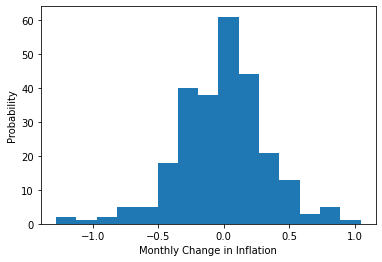

In [762]:
plt.hist(MonM_main['Inflation'], bins=15)
plt.xlabel('Monthly Change in Inflation')
plt.ylabel('Probability')

Not perfectly normal but we will proceed.

In [763]:
MonM_main.corr(method='pearson')

,Inflation,Wage CPI,WTI,Copper,Soybeans,Natural Gas,Heating Oil,Corn,Wheat,Cattle,Lean Hogs,Sugar,Lumber,Capacity Utilization,USD Index,Initial Jobless Claims,Unemployment Rate
Inflation,1.000000,0.738433,0.316557,0.098236,0.072840,0.147131,0.334497,0.056072,-0.069988,0.034864,0.034798,0.167506,0.136458,0.252918,-0.114967,-0.044166,-0.209657
Wage CPI,0.738433,1.000000,0.365632,0.203881,0.079959,0.152561,0.388011,-0.002302,-0.014584,0.080827,0.001655,0.143099,0.144728,0.227783,-0.172356,-0.021098,-0.173623
WTI,0.316557,0.365632,1.000000,0.386433,0.124127,0.230201,0.827850,0.051022,-0.035981,0.084882,0.067227,0.111518,0.165072,0.206047,-0.267817,-0.259654,-0.064245
Copper,0.098236,0.203881,0.386433,1.000000,0.241581,0.009523,0.345123,0.101708,0.054382,0.130041,0.148876,0.201839,0.184623,0.090496,-0.269006,-0.135575,0.016567
Soybeans,0.072840,0.079959,0.124127,0.241581,1.000000,0.050149,0.139870,0.670791,0.423782,0.092895,0.162238,0.159430,0.149472,0.075764,-0.144713,0.004803,-0.050087
Natural Gas,0.147131,0.152561,0.230201,0.009523,0.050149,1.000000,0.317279,0.068595,0.024227,-0.054168,0.059041,0.082018,-0.055373,-0.005810,-0.140713,-0.083967,-0.060568
Heating Oil,0.334497,0.388011,0.827850,0.345123,0.139870,0.317279,1.000000,0.061157,0.023143,0.076941,0.023740,0.103170,0.098917,0.221721,-0.188347,-0.144574,-0.096566
Corn,0.056072,-0.002302,0.051022,0.101708,0.670791,0.068595,0.061157,1.000000,0.564450,-0.032807,0.130284,0.100297,0.085288,0.099236,-0.096298,-0.027443,-0.101232
Wheat,-0.069988,-0.014584,-0.035981,0.054382,0.423782,0.024227,0.023143,0.564450,1.000000,0.035376,0.030570,0.099528,0.055731,0.062248,-0.064679,0.056926,-0.109013
Cattle,0.034864,0.080827,0.084882,0.130041,0.092895,-0.054168,0.076941,-0.032807,0.035376,1.000000,0.181887,0.077284,0.149907,0.116523,-0.021571,-0.132705,-0.123911


{'whiskers': [<matplotlib.lines.Line2D at 0x2b647bbd160>,
 'caps': [<matplotlib.lines.Line2D at 0x2b647bbd820>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b647b97dc0>],
 'medians': [<matplotlib.lines.Line2D at 0x2b647bbdee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b647bc7280>],
 'means': []}

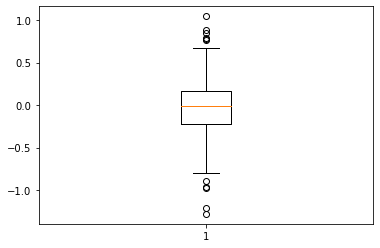

In [764]:
plt.boxplot(MonM_main['Inflation'])

Text(0.5, 1.0, 'Month on Month Comparison')

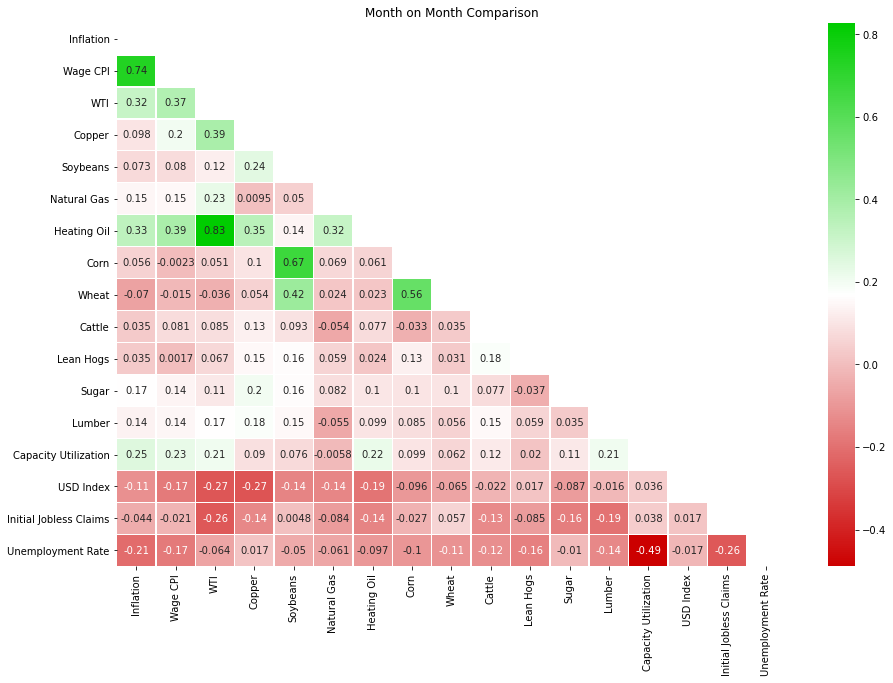

In [765]:
plt.subplots(figsize=(15,10))
matrix = np.triu(MonM_main.corr())
sns.heatmap(MonM_main.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Month on Month Comparison')

In [766]:
MonM_main = MonM_main.sort_values(by="Date", ascending=True)
MonM_main_csv = pd.DataFrame(MonM_main)

MonM_main_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/MonM_main.xlsx')
print('Finished')

Finished


# 1.3.3 Quarterly Changes | Variables ( past ) & Inflation ( forwards )<a id='2.5_Load_The_Ski_Resort_Data'></a>

In 1.3.3 I will be setting up the infrastructure to **compare quarterly changes on all variables ( one quarter in the past )** against a **quarterly change in inflation ( one quarter in the future )** to ascertain if there's any relationship to **predict** `Inflation` one quarter in advance.  

In [767]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index = usd_index['Settle'].pct_change(periods=66)
Q_wti = wti['Last'].pct_change(periods=66)

Q_copper = copper['Close'].pct_change(periods=66)
Q_soybeans = soybeans['Close'].pct_change(periods=66)
Q_natgas = natgas['Close'].pct_change(periods=66)
Q_heatoil = heatoil['Close'].pct_change(periods=66)
Q_corn = corn['Close'].pct_change(periods=66)
Q_wheat = wheat['Close'].pct_change(periods=66)
Q_cattle = cattle['Close'].pct_change(periods=66)
Q_sugar = sugar['Close'].pct_change(periods=66)
Q_lumber = lumber['Close'].pct_change(periods=66)
Q_leanhogs = leanhogs['Close'].pct_change(periods=66)

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs = int_job_claims.diff(periods=12)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil = cap_util.pct_change(periods=3)
Q_wages = wages_cpi.pct_change(periods=3)
Q_cpi_past = cpi.diff(periods=-3)
M_unrate = unrate.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)

Checking to see if the `Inflation` function works as I intend 

In [768]:
# To compare what the function is returning
Q_cpi_past.tail(5)

,Value
Date,
2020-09-30,0.009
2020-10-31,-0.218
2020-11-30,NaN
2020-12-31,NaN
2021-01-31,NaN


In [769]:
# I start with the actual data
cpi.tail(10)

,Value
Date,
2020-04-30,0.329
2020-05-31,0.118
2020-06-30,0.646
2020-07-31,0.986
2020-08-31,1.310
2020-09-30,1.371
2020-10-31,1.182
2020-11-30,1.175
2020-12-31,1.362


In [770]:
print('The 31 Jan 2021 # of 1.4 minus 3 months before ( 2020-10-31 ) show: ', round((1.400-1.182),3) )

The 31 Jan 2021 # of 1.4 minus 3 months before ( 2020-10-31 ) show:  0.218


This **appears to be incorrect,** meaning it should be a positive number but shows a negative number in the `Q_cpi_p` tail. **Let's check the one behind to see what that shows.**

In [771]:
print('The 31 Dec 2020 # of 1.362 minus 3 months before ( 30 Sept 2020 ) show: ', round((1.362-1.371),3) )

The 31 Dec 2020 # of 1.362 minus 3 months before ( 30 Sept 2020 ) show:  -0.009


This shows a negative number while the function shows a positive. It appears as though the function need to be multiplied by -1 to show the correct #. 

**We will change the** `Q_cpi_p` **# below.**

In [772]:
Q_cpi_past = cpi.diff(periods=-3) * -1

Double check:

In [773]:
Q_cpi_past.tail(5)

,Value
Date,
2020-09-30,-0.009
2020-10-31,0.218
2020-11-30,NaN
2020-12-31,NaN
2021-01-31,NaN


We have "righted the wrong"; ready to proceed.

In [774]:
# Putting them together with inflation
QonQ_main_cpi_past = Q_cpi_past.merge(QonQ_vars, how='left', on='Date')

QonQ_main_cpi_past= QonQ_main_cpi_past[QonQ_main_cpi_past.index.dayofweek < 5]

QonQ_main_cpi_past.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','GDP','M2 Velocity','Wheat',
                     'USD Index','Initial Jobless Claims','Unemployment Rate']

QonQ_main_cpi_past = QonQ_main_cpi_past.dropna()

In [775]:
QonQ_main_cpi_past.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 257 entries, 1990-07-31 to 2020-09-30
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               257 non-null    float64
 1   Wage CPI                257 non-null    float64
 2   WTI                     257 non-null    float64
 3   Heating Oil             257 non-null    float64
 4   Copper                  257 non-null    float64
 5   Sugar                   257 non-null    float64
 6   Natural Gas             257 non-null    float64
 7   Cattle                  257 non-null    float64
 8   Lean Hogs               257 non-null    float64
 9   Soybeans                257 non-null    float64
 10  Lumber                  257 non-null    float64
 11  Capacity Utilization    257 non-null    float64
 12  Corn                    257 non-null    float64
 13  GDP                     257 non-null    float64
 14  M2 Velocity            

# 1.3.3.2 Cleaning the Variable ( past ) & Inflation ( forwards ) Dataframe for outliers 

Here's where are will see if this Dataframe needs cleaning for outliers.

In [776]:
QonQ_main_cpi_past.corr(method='pearson')

,Inflation,Wage CPI,WTI,Heating Oil,Copper,Sugar,Natural Gas,Cattle,Lean Hogs,Soybeans,Lumber,Capacity Utilization,Corn,GDP,M2 Velocity,Wheat,USD Index,Initial Jobless Claims,Unemployment Rate
Inflation,1.000000,-0.005418,0.189752,0.221146,0.267744,0.200457,0.103356,-0.038801,-0.009406,0.205365,0.061134,0.175472,0.170258,0.029351,0.037738,0.099514,-0.233913,-0.070336,-0.000968
Wage CPI,-0.005418,1.000000,0.410626,0.504927,0.328430,0.189844,0.306341,0.201598,0.114678,0.137186,0.101049,0.243479,0.070015,0.285482,0.305496,-0.003589,-0.296041,-0.087025,-0.232243
WTI,0.189752,0.410626,1.000000,0.802134,0.426525,0.178585,0.251333,0.155137,0.126634,0.148033,0.277946,0.421905,0.030280,0.291743,0.178841,-0.014931,-0.268676,-0.430420,-0.258419
Heating Oil,0.221146,0.504927,0.802134,1.000000,0.412319,0.161142,0.416604,0.148812,0.087489,0.155272,0.127508,0.360968,0.035564,0.248533,0.239223,-0.003163,-0.305653,-0.276944,-0.242354
Copper,0.267744,0.328430,0.426525,0.412319,1.000000,0.249795,0.088585,0.118183,0.145587,0.197480,0.205517,0.239896,0.097817,0.152232,0.141746,0.079644,-0.349134,-0.171255,-0.083298
Sugar,0.200457,0.189844,0.178585,0.161142,0.249795,1.000000,0.151099,0.025846,-0.088339,0.125076,0.081984,0.175464,0.068128,0.126382,0.111961,0.083869,-0.136537,-0.127992,-0.111401
Natural Gas,0.103356,0.306341,0.251333,0.416604,0.088585,0.151099,1.000000,0.015168,0.023244,0.059987,-0.067020,0.130243,0.076645,0.102074,0.086639,0.011871,-0.241751,-0.051756,-0.065028
Cattle,-0.038801,0.201598,0.155137,0.148812,0.118183,0.025846,0.015168,1.000000,0.175087,0.083880,0.198502,0.313589,0.026580,0.247849,0.206656,0.010829,-0.048262,-0.175268,-0.283165
Lean Hogs,-0.009406,0.114678,0.126634,0.087489,0.145587,-0.088339,0.023244,0.175087,1.000000,0.205881,0.178826,0.153925,0.234147,0.159236,0.123406,0.032497,0.038910,-0.047075,-0.122922
Soybeans,0.205365,0.137186,0.148033,0.155272,0.197480,0.125076,0.059987,0.083880,0.205881,1.000000,0.192435,0.123891,0.700597,0.050666,0.046941,0.435093,-0.137291,-0.050691,-0.047462


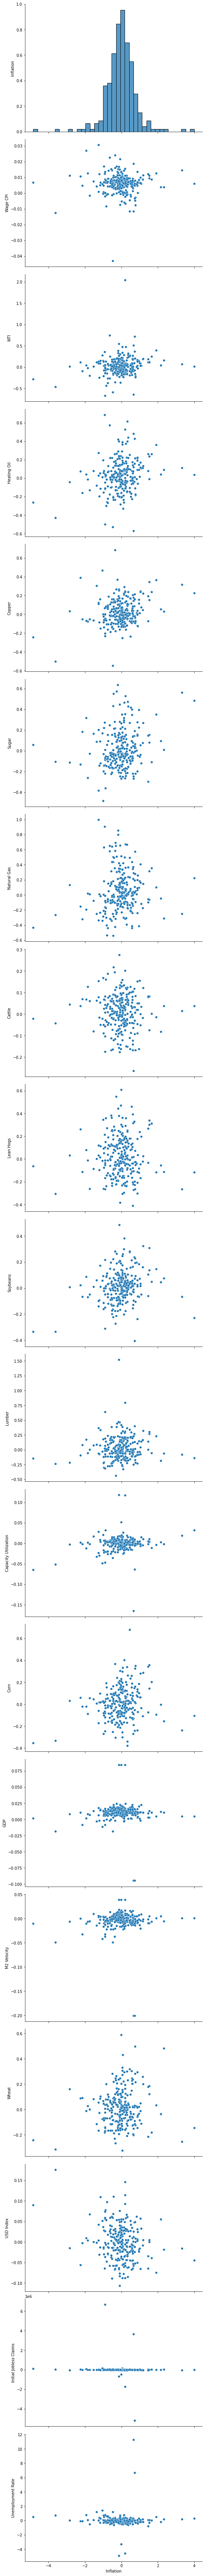

In [777]:
sns.pairplot(QonQ_main_cpi_past,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','GDP','M2 Velocity','Wheat',
                     'USD Index','Initial Jobless Claims','Unemployment Rate'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

Let's check this out on a histogram

Text(0, 0.5, 'Probability')

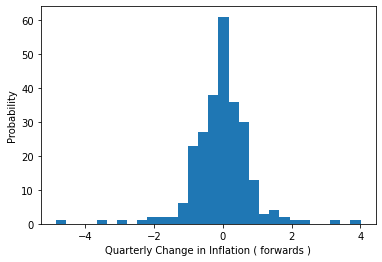

In [778]:
plt.hist(QonQ_main_cpi_past['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation ( forwards )')
plt.ylabel('Probability')

Noticeable outliers; let's check where they are.

In [779]:
cpi_outliers = np.abs(stats.zscore(QonQ_main_cpi_past['Inflation']))
threshold = 3
print(np.where(cpi_outliers >= threshold ))

(array([135, 154, 155, 161, 162], dtype=int64),)


In [780]:
QonQ_main_cpi_past['Inflation'][135],QonQ_main_cpi_past['Inflation'][154],QonQ_main_cpi_past['Inflation'][155],QonQ_main_cpi_past['Inflation'][161],QonQ_main_cpi_past['Inflation'][162]

(-2.84, -4.846, -3.625, 3.322, 4.007)

We will scrape all 5 representing 1.9% of the dataframe.

In [781]:
rows_to_drop = [135, 154, 155, 161, 162]
QonQ_main_cpi_past.drop(QonQ_main_cpi_past.index[rows_to_drop], inplace=True)

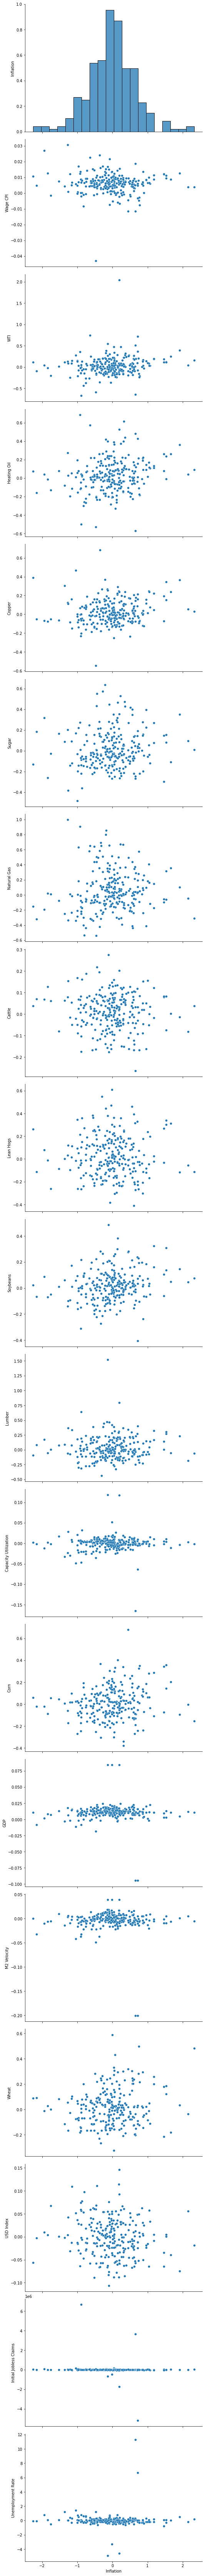

In [782]:
sns.pairplot(QonQ_main_cpi_past,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','GDP','M2 Velocity','Wheat',
                     'USD Index','Initial Jobless Claims','Unemployment Rate'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

Text(0, 0.5, 'Probability')

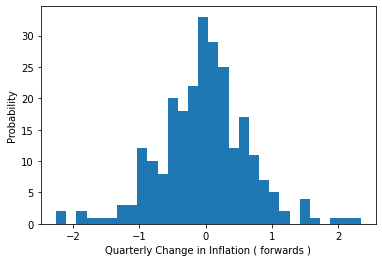

In [783]:
plt.hist(QonQ_main_cpi_past['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation ( forwards )')
plt.ylabel('Probability')

In [784]:
QonQ_main_cpi_past.corr(method='pearson')

,Inflation,Wage CPI,WTI,Heating Oil,Copper,Sugar,Natural Gas,Cattle,Lean Hogs,Soybeans,Lumber,Capacity Utilization,Corn,GDP,M2 Velocity,Wheat,USD Index,Initial Jobless Claims,Unemployment Rate
Inflation,1.000000,-0.078634,0.154610,0.168301,0.139950,0.122741,0.068452,-0.075472,-0.013594,0.187425,0.035202,0.022051,0.157333,-0.009180,-0.019116,0.110158,-0.135708,-0.082589,0.016576
Wage CPI,-0.078634,1.000000,0.399018,0.495099,0.296250,0.179084,0.308531,0.197439,0.105837,0.116767,0.095657,0.224966,0.055594,0.273046,0.289036,-0.023628,-0.265558,-0.087883,-0.230665
WTI,0.154610,0.399018,1.000000,0.796247,0.407136,0.180784,0.238366,0.149801,0.112004,0.113435,0.267413,0.403495,-0.002697,0.276329,0.161406,-0.045651,-0.235362,-0.435137,-0.253526
Heating Oil,0.168301,0.495099,0.796247,1.000000,0.383781,0.157158,0.408357,0.143297,0.071400,0.116465,0.110479,0.332186,-0.000310,0.230199,0.220601,-0.034473,-0.267900,-0.280823,-0.237434
Copper,0.139950,0.296250,0.407136,0.383781,1.000000,0.221154,0.066704,0.108936,0.141064,0.164511,0.200157,0.175942,0.068020,0.129557,0.109997,0.057426,-0.291131,-0.177276,-0.076262
Sugar,0.122741,0.179084,0.180784,0.157158,0.221154,1.000000,0.164145,0.022880,-0.069481,0.159126,0.094701,0.155247,0.098111,0.136612,0.106129,0.122457,-0.124536,-0.131203,-0.119322
Natural Gas,0.068452,0.308531,0.238366,0.408357,0.066704,0.164145,1.000000,0.008398,0.006618,0.030398,-0.080189,0.101389,0.044849,0.089011,0.076280,-0.018723,-0.219046,-0.051088,-0.059003
Cattle,-0.075472,0.197439,0.149801,0.143297,0.108936,0.022880,0.008398,1.000000,0.173389,0.078306,0.199147,0.313514,0.018470,0.245356,0.202800,0.002366,-0.034546,-0.175017,-0.281952
Lean Hogs,-0.013594,0.105837,0.112004,0.071400,0.141064,-0.069481,0.006618,0.173389,1.000000,0.179663,0.165611,0.148673,0.208909,0.141906,0.111594,-0.002761,0.070782,-0.047675,-0.116596
Soybeans,0.187425,0.116767,0.113435,0.116465,0.164511,0.159126,0.030398,0.078306,0.179663,1.000000,0.167324,0.080986,0.684344,0.015305,0.021690,0.403428,-0.084141,-0.051011,-0.032578


Looks fairly similar to a normal distribution; I will continue as such.

{'whiskers': [<matplotlib.lines.Line2D at 0x2b64c5c0670>,
 'caps': [<matplotlib.lines.Line2D at 0x2b64c5c0250>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b64a2e9190>],
 'medians': [<matplotlib.lines.Line2D at 0x2b64c5c0ac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b64c5c0880>],
 'means': []}

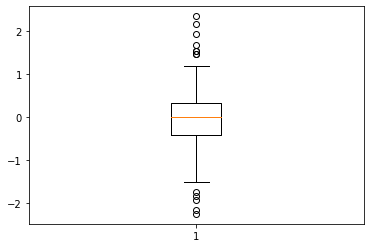

In [785]:
plt.boxplot(QonQ_main_cpi_past['Inflation'])

Text(0.5, 1.0, 'Inflation ( 1 Quarter Forwards ) vs. Variables ( 1 Quarter Backwards)')

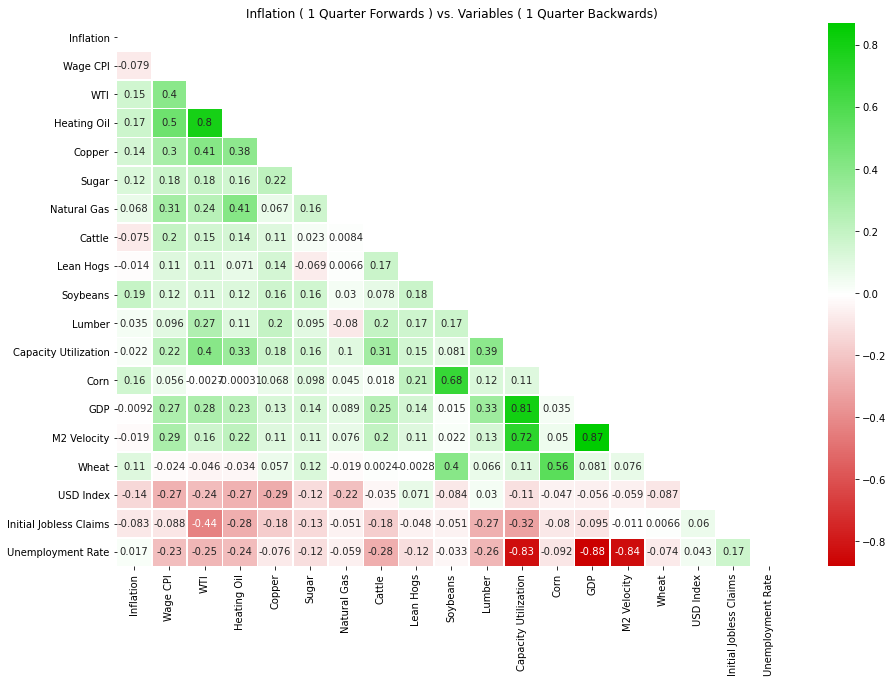

In [786]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_cpi_past.corr())
sns.heatmap(QonQ_main_cpi_past.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Inflation ( 1 Quarter Forwards ) vs. Variables ( 1 Quarter Backwards)')

In [787]:
QonQ_main_cpi_past = QonQ_main_cpi_past.sort_values(by="Date", ascending=True)
QonQ_main_cpi_past_csv = pd.DataFrame(QonQ_main_cpi_past)

QonQ_main_cpi_past_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_main_cpi_past.xlsx')
print('Finished')

Finished


# 1.3.4   |   Q on Q Comparison w/ Rolling Averages on Daily & Wkly Variables

**This dataframe is being constructed a similar way 1.3.1 was created with the exception that the daily, weekly & monthly variables are taking a rolling average.** The rational with this interest is based on the idea that one of the variables would have had a bad day / week at the end of the term. If so, they may not properly display the impact they may have on inflation.

In [788]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index_roll = Q_usd_index.rolling(66).mean()
Q_wti_roll = Q_wti.rolling(66).mean()

Q_copper_roll = Q_copper.rolling(66).mean()
Q_soybeans_roll = Q_soybeans.rolling(66).mean()
Q_natgas_roll = Q_natgas.rolling(66).mean()
Q_heatoil_roll = Q_heatoil.rolling(66).mean()
Q_corn_roll = Q_corn.rolling(66).mean()
Q_wheat_roll = Q_wheat.rolling(66).mean()
Q_cattle_roll = Q_cattle.rolling(66).mean()
Q_sugar_roll = Q_sugar.rolling(66).mean()
Q_lumber_roll = Q_lumber.rolling(66).mean()
Q_leanhogs_roll = Q_leanhogs.rolling(66).mean()

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs_roll = Q_intjobs.rolling(12).mean()

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil_roll = Q_caputil.rolling(3).mean()
Q_wages_roll = Q_wages.rolling(3).mean()
Q_unrate_roll = Q_unrate.rolling(3).mean()

Q_cpi = cpi.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)

In [789]:
# Building out the variables first with a roll & forward fill
QonQ_vars_roll = pd.concat([Q_wages_roll,Q_wti_roll,Q_copper_roll,Q_soybeans_roll,Q_natgas_roll,
                       Q_heatoil_roll,Q_corn_roll,Q_wheat_roll,Q_cattle_roll,Q_leanhogs_roll,Q_sugar_roll,
                       Q_lumber_roll,Q_caputil_roll,Q_gdp,Q_m2_velo,Q_usd_index_roll,Q_intjobs_roll,Q_unrate_roll
                      ],
                      axis = 1, ignore_index=False)

QonQ_vars_roll.columns= ['Wages CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','GDP','M2 Velocity','USD Index','Initial Jobless Claims',
                         'Unemployment Rate'
                   ]

QonQ_vars_roll.index.names = ["Date"]
QonQ_vars_roll = QonQ_vars_roll.fillna(method='ffill')

# vars_mnth.tail()

In [790]:
QonQ_vars_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14113 entries, 1946-01-01 to 2021-02-24
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wages CPI               14104 non-null  float64
 1   WTI                     11899 non-null  float64
 2   Copper                  10251 non-null  float64
 3   Soybeans                9810 non-null   float64
 4   Natural Gas             9726 non-null   float64
 5   Heating Oil             12898 non-null  float64
 6   Corn                    12897 non-null  float64
 7   Wheat                   9812 non-null   float64
 8   Cattle                  12895 non-null  float64
 9   Lean Hogs               12900 non-null  float64
 10  Sugar                   12898 non-null  float64
 11  Lumber                  12900 non-null  float64
 12  Capacity Utilization    13844 non-null  float64
 13  GDP                     14106 non-null  float64
 14  M2 Velocity          

In [791]:
# As before, working backwards off of Natural Gas to bring the data together
# QonQ_vars_roll['Natural Gas'].tail(9565)

QonQ_vars_roll = QonQ_vars_roll.loc['1991-04-18':today_y_m_d_dash]

In [792]:
QonQ_vars_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9563 entries, 1991-04-18 to 2021-02-24
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wages CPI               9563 non-null   float64
 1   WTI                     9563 non-null   float64
 2   Copper                  9563 non-null   float64
 3   Soybeans                9563 non-null   float64
 4   Natural Gas             9563 non-null   float64
 5   Heating Oil             9563 non-null   float64
 6   Corn                    9563 non-null   float64
 7   Wheat                   9563 non-null   float64
 8   Cattle                  9563 non-null   float64
 9   Lean Hogs               9563 non-null   float64
 10  Sugar                   9563 non-null   float64
 11  Lumber                  9563 non-null   float64
 12  Capacity Utilization    9563 non-null   float64
 13  GDP                     9563 non-null   float64
 14  M2 Velocity           

In [794]:
# Putting them together with inflation
QonQ_main_roll = Q_cpi.merge(QonQ_vars_roll, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll.columns = ['Inflation','Wages CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','GDP','M2 Velocity','USD Index','Initial Jobless Claims',
                         'Unemployment Rate']

QonQ_main_roll = QonQ_main_roll.dropna()

In [795]:
QonQ_main_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 1991-04-30 to 2021-01-31
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               315 non-null    float64
 1   Wages CPI               315 non-null    float64
 2   WTI                     315 non-null    float64
 3   Copper                  315 non-null    float64
 4   Soybeans                315 non-null    float64
 5   Natural Gas             315 non-null    float64
 6   Heating Oil             315 non-null    float64
 7   Corn                    315 non-null    float64
 8   Wheat                   315 non-null    float64
 9   Cattle                  315 non-null    float64
 10  Lean Hogs               315 non-null    float64
 11  Sugar                   315 non-null    float64
 12  Lumber                  315 non-null    float64
 13  Capacity Utilization    315 non-null    float64
 14  GDP                    

# 1.3.4.2 Cleaning the Dataframe for outliers 

In [796]:
QonQ_main_roll.corr(method='pearson')

,Inflation,Wages CPI,WTI,Copper,Soybeans,Natural Gas,Heating Oil,Corn,Wheat,Cattle,Lean Hogs,Sugar,Lumber,Capacity Utilization,GDP,M2 Velocity,USD Index,Initial Jobless Claims,Unemployment Rate
Inflation,1.000000,0.565987,0.520343,0.350230,0.174340,0.306085,0.525608,0.244616,0.120482,0.146786,0.212232,0.219102,0.174071,0.342820,0.306416,0.294116,-0.315753,-0.257800,-0.209100
Wages CPI,0.565987,1.000000,0.712886,0.510164,0.241096,0.404527,0.732853,0.212270,0.141778,0.246435,0.240171,0.230867,0.192688,0.385995,0.299592,0.340298,-0.394085,-0.204241,-0.301459
WTI,0.520343,0.712886,1.000000,0.560650,0.258679,0.349431,0.902690,0.116587,0.040497,0.162890,0.289866,0.215882,0.310672,0.478661,0.459799,0.429772,-0.406236,-0.432977,-0.324661
Copper,0.350230,0.510164,0.560650,1.000000,0.252599,0.173464,0.537572,0.141006,0.151463,0.119943,0.186921,0.295286,0.222888,0.336307,0.243688,0.269319,-0.411457,-0.190292,-0.152743
Soybeans,0.174340,0.241096,0.258679,0.252599,1.000000,0.101293,0.224292,0.719497,0.458404,0.069074,0.215068,0.139238,0.197200,0.163464,0.063710,0.062677,-0.268120,-0.100176,-0.118077
Natural Gas,0.306085,0.404527,0.349431,0.173464,0.101293,1.000000,0.476638,0.111541,0.035351,0.142327,0.085929,0.234720,-0.066601,0.264894,0.140599,0.139664,-0.238806,-0.125982,-0.163239
Heating Oil,0.525608,0.732853,0.902690,0.537572,0.224292,0.476638,1.000000,0.103521,0.058695,0.218795,0.160532,0.256509,0.182754,0.468512,0.377837,0.400631,-0.399799,-0.330734,-0.322216
Corn,0.244616,0.212270,0.116587,0.141006,0.719497,0.111541,0.103521,1.000000,0.577482,0.057550,0.204855,0.088798,0.119822,0.189856,0.078331,0.082967,-0.184178,-0.101659,-0.152027
Wheat,0.120482,0.141778,0.040497,0.151463,0.458404,0.035351,0.058695,0.577482,1.000000,0.055742,-0.099823,0.084430,0.039197,0.165687,0.048848,0.070621,-0.203491,-0.035294,-0.105712
Cattle,0.146786,0.246435,0.162890,0.119943,0.069074,0.142327,0.218795,0.057550,0.055742,1.000000,0.122089,0.093854,0.244684,0.383941,0.255673,0.273100,-0.074946,-0.253942,-0.354701


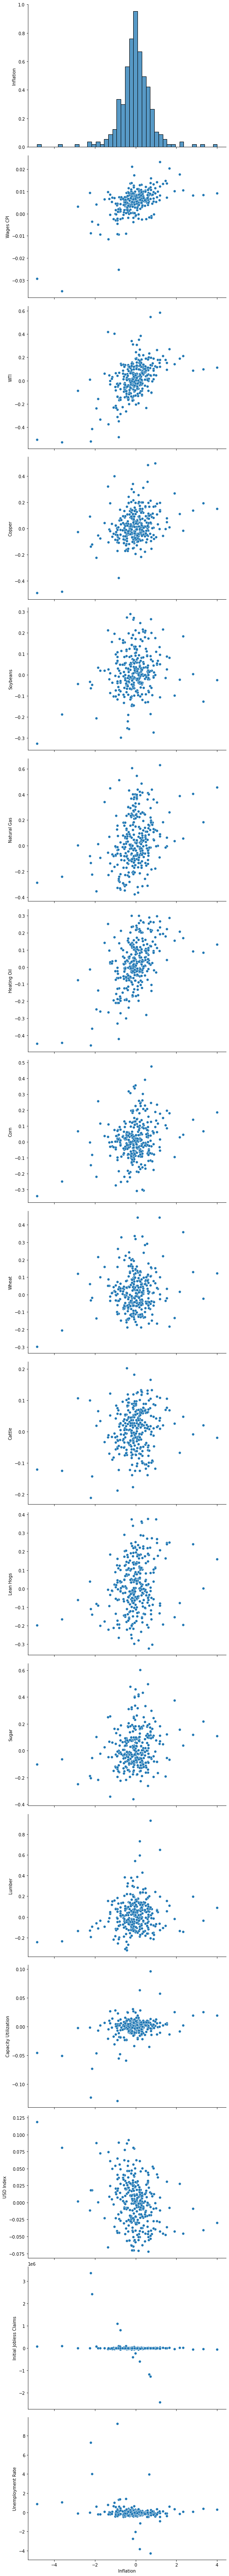

In [797]:
sns.pairplot(QonQ_main_roll,
            y_vars=['Inflation','Wages CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','USD Index','Initial Jobless Claims','Unemployment Rate'],
            x_vars=['Inflation'],
            height=5, aspect=1.5,)

Text(0, 0.5, 'Probability')

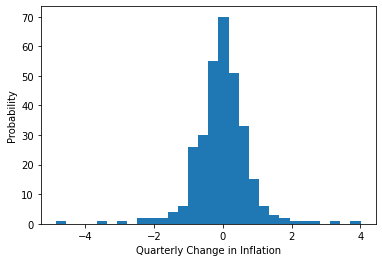

In [798]:
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Probability')

Given the Inflation data hasn't been changed since 1.31; we will scrape anything ± 300 bps

In [799]:
cpi_review = np.abs(stats.zscore(QonQ_main_roll['Inflation']))
threshold = 3
print( np.where( cpi_review > threshold ) )

(array([156, 178, 179, 188, 189, 190], dtype=int64),)


In [800]:
QonQ_main_roll['Inflation'][156],QonQ_main_roll['Inflation'][178],QonQ_main_roll['Inflation'][179],QonQ_main_roll['Inflation'][188],QonQ_main_roll['Inflation'][189],QonQ_main_roll['Inflation'][190]

(-2.84, -4.846, -3.625, 3.322, 4.007, 2.8089999999999997)

In [801]:
droppingrows = [ 178, 179, 188, 189 ]
QonQ_main_roll.drop(QonQ_main_roll.index[droppingrows], inplace=True)

Text(0, 0.5, 'Probability')

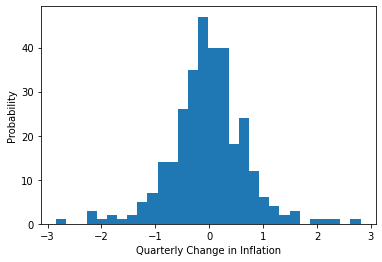

In [802]:
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Probability')

In [803]:
QonQ_main_roll.corr(method='pearson')

,Inflation,Wages CPI,WTI,Copper,Soybeans,Natural Gas,Heating Oil,Corn,Wheat,Cattle,Lean Hogs,Sugar,Lumber,Capacity Utilization,GDP,M2 Velocity,USD Index,Initial Jobless Claims,Unemployment Rate
Inflation,1.000000,0.477351,0.483253,0.226182,0.130479,0.258576,0.491668,0.162078,0.034545,0.106733,0.182445,0.202604,0.142065,0.271498,0.287430,0.261349,-0.235765,-0.291309,-0.221271
Wages CPI,0.477351,1.000000,0.688178,0.414485,0.160065,0.400880,0.718875,0.125836,0.047689,0.198130,0.212949,0.235034,0.144871,0.326555,0.264810,0.311333,-0.330877,-0.225727,-0.302518
WTI,0.483253,0.688178,1.000000,0.512829,0.214378,0.328236,0.894309,0.058836,-0.018285,0.126026,0.269399,0.206650,0.286702,0.444111,0.440604,0.407738,-0.363566,-0.445597,-0.315694
Copper,0.226182,0.414485,0.512829,1.000000,0.204979,0.132107,0.489967,0.071836,0.091095,0.074167,0.157112,0.288226,0.191662,0.279498,0.207494,0.232320,-0.359201,-0.194121,-0.135417
Soybeans,0.130479,0.160065,0.214378,0.204979,1.000000,0.083765,0.179611,0.715396,0.434954,0.037329,0.197865,0.138238,0.172811,0.132835,0.033181,0.034522,-0.235890,-0.099544,-0.100432
Natural Gas,0.258576,0.400880,0.328236,0.132107,0.083765,1.000000,0.462003,0.079074,0.005748,0.129570,0.067185,0.225224,-0.086979,0.238601,0.123489,0.119446,-0.211707,-0.123663,-0.159103
Heating Oil,0.491668,0.718875,0.894309,0.489967,0.179611,0.462003,1.000000,0.046687,0.003237,0.187088,0.133557,0.248909,0.152794,0.434329,0.354478,0.377237,-0.358021,-0.337570,-0.313412
Corn,0.162078,0.125836,0.058836,0.071836,0.715396,0.079074,0.046687,1.000000,0.558537,0.029067,0.183285,0.074884,0.094307,0.147739,0.048126,0.051020,-0.138541,-0.098738,-0.140693
Wheat,0.034545,0.047689,-0.018285,0.091095,0.434954,0.005748,0.003237,0.558537,1.000000,0.027964,-0.129343,0.074988,0.011229,0.128911,0.019439,0.041503,-0.164325,-0.031452,-0.091698
Cattle,0.106733,0.198130,0.126026,0.074167,0.037329,0.129570,0.187088,0.029067,0.027964,1.000000,0.108283,0.086925,0.229580,0.366500,0.238886,0.257127,-0.042055,-0.253984,-0.346682


{'whiskers': [<matplotlib.lines.Line2D at 0x2b64fac8d90>,
 'caps': [<matplotlib.lines.Line2D at 0x2b64fad5310>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b64fac8c70>],
 'medians': [<matplotlib.lines.Line2D at 0x2b64fafb0d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b64fafb430>],
 'means': []}

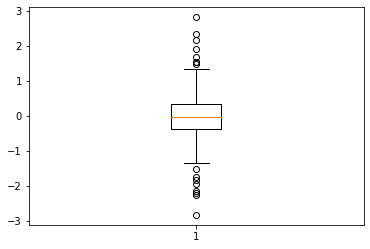

In [804]:
plt.boxplot(QonQ_main_roll['Inflation'])

Text(0.5, 1.0, 'Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables)')

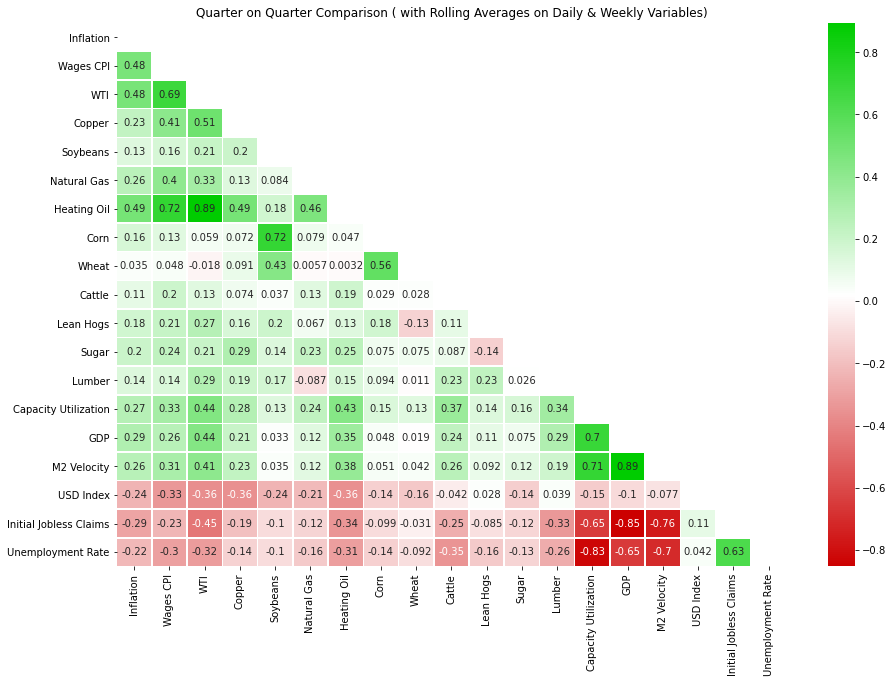

In [805]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_roll.corr())
sns.heatmap(QonQ_main_roll.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables)')

In [806]:
QonQ_main_roll = QonQ_main_roll.sort_values(by="Date", ascending=False)
QonQ_main_roll_csv = pd.DataFrame(QonQ_main_roll)

QonQ_main_roll_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_main_roll.xlsx')
print('Finished')

Finished


# 1.4 Summary

# 1.4.1 Looking into Natural Gas

**Natural Gas was one of the variables which confined the length / depth of the dataframe.** Here we will ascertain whether or not we could remove it for the following possible reasons:
   * It's influence on Inflation is accounted for with other fossil fuels 
   * It's influence by itself is notable

In [312]:
# Creating "new quarterly variables"

Q_wti_2 = Q_wti 
Q_heatoil_2 = Q_heatoil
Q_natgas_2 = Q_natgas
Q_cpi_2 = Q_cpi

In [304]:
fos_fuel_main = pd.concat([Q_wti_2,Q_heatoil_2,Q_natgas_2],
                         axis=1,ignore_index=False)

fos_fuel_main.columns = ['WTI','Heating Oil','Natural Gas']
fos_fuel_main.index.names = ["Date"]
fos_fuel_main = fos_fuel_main.fillna(method='ffill')

fos_fuel = Q_cpi_2.merge(fos_fuel_main,
                        how='left',on="Date")

fos_fuel.columns =['Inflation','WTI','Heating Oil','Natural Gas']

fos_fuel = fos_fuel.dropna()

Comparing the fossil fuels together to inflation.

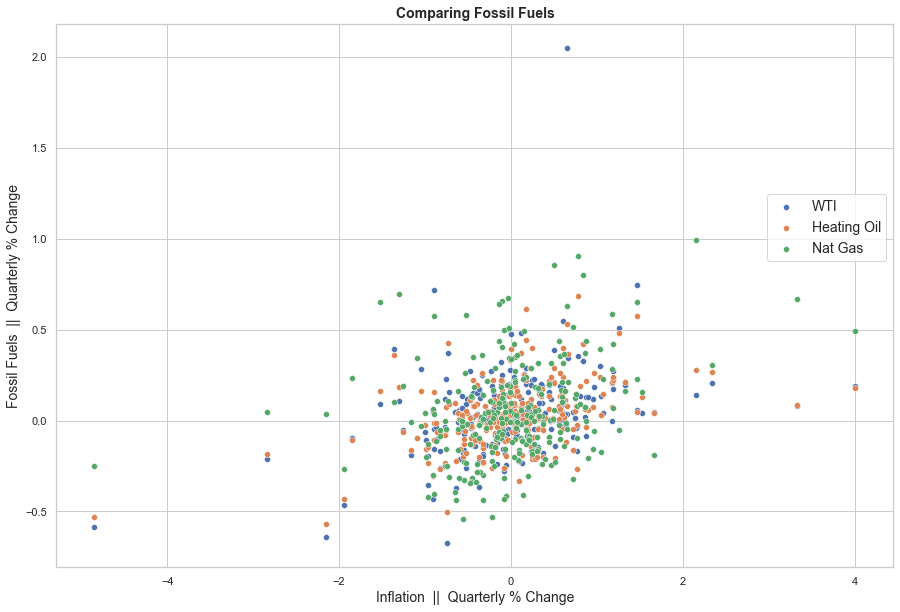

In [305]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['WTI'])
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['Heating Oil'])
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['Natural Gas'])
sns.set(style='whitegrid',)
plt.ylabel('Fossil Fuels  ||  Quarterly % Change', fontsize=14)
plt.xlabel('Inflation  ||  Quarterly % Change', fontsize=14)
plt.legend(['WTI','Heating Oil','Nat Gas'], scatterpoints=1,bbox_to_anchor=(1, 0.7),fontsize=14)
plt.title('Comparing Fossil Fuels', fontsize=14, fontdict=fontdict)
plt.show()

There appears to be one (1) outlier in WTI ( which was seen before ) which we will remove for further review.

In [306]:
wti_check = np.abs(stats.zscore(fos_fuel['WTI']))
threshold = 3
print(np.where( wti_check > threshold) )

(array([  2, 248, 249, 250, 251], dtype=int64),)


In [307]:
fos_fuel['WTI'][2],fos_fuel['WTI'][248],fos_fuel['WTI'][249],fos_fuel['WTI'][250],fos_fuel['WTI'][251]

(0.743196437407224,
 -0.6712463199214916,
 -0.6386522809010032,
 0.7178602243313201,
 2.046721929163527)

In [308]:
wtidrop_row = [251]
fos_fuel.drop(fos_fuel.index[wtidrop_row], inplace=True)

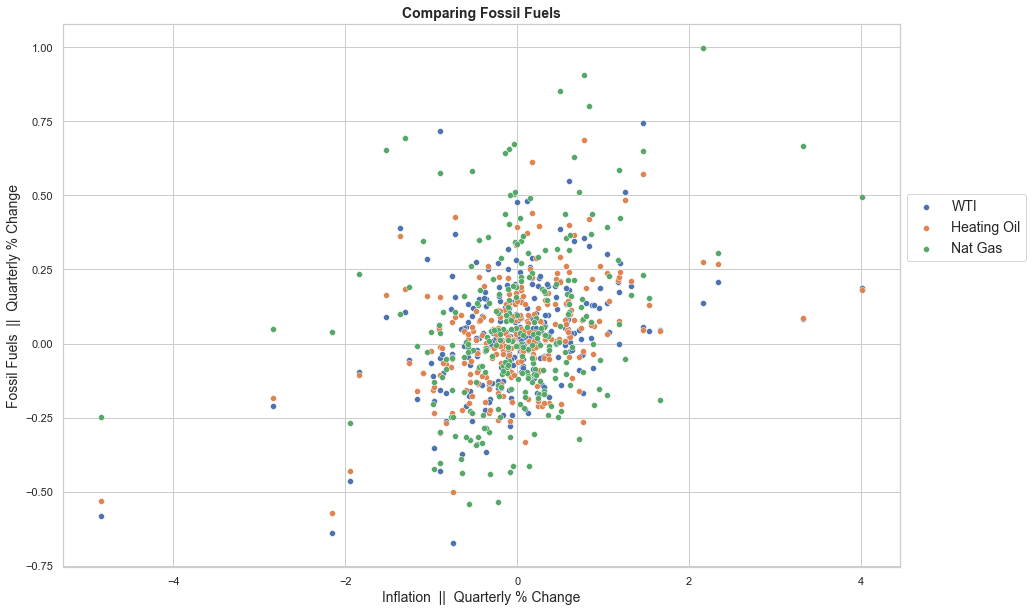

In [309]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['WTI'])
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['Heating Oil'])
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['Natural Gas'])
sns.set(style='whitegrid',)
plt.ylabel('Fossil Fuels  ||  Quarterly % Change', fontsize=14)
plt.xlabel('Inflation  ||  Quarterly % Change', fontsize=14)
plt.legend(['WTI','Heating Oil','Nat Gas'], scatterpoints=1,bbox_to_anchor=(1, 0.7),fontsize=14)
plt.title('Comparing Fossil Fuels', fontsize=14, fontdict=fontdict)
plt.show()

Visually these appear quite correlated or in other words possibly accounted for with WTI & Heating Oil.

Text(0.5, 1.0, 'Fossil Fuels Heatmap)')

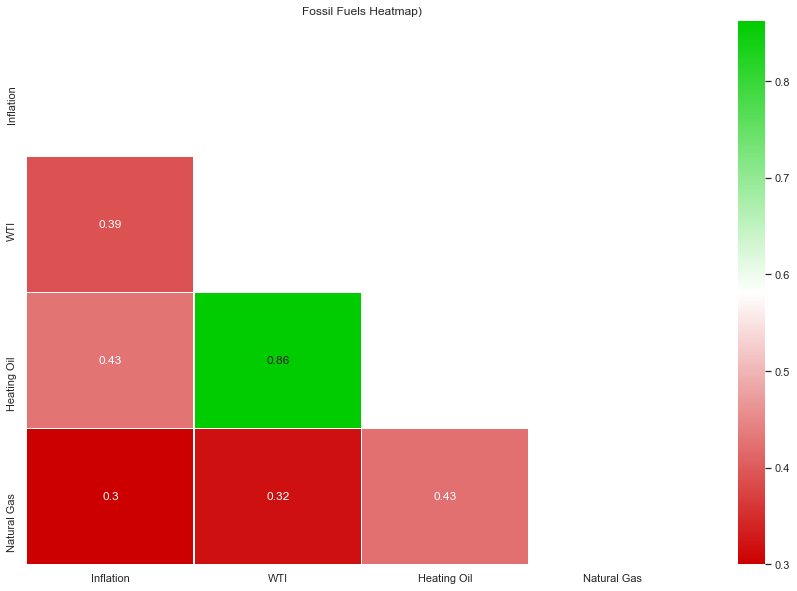

In [311]:
plt.subplots(figsize=(15,10))
matrix = np.triu(fos_fuel.corr())
sns.heatmap(fos_fuel.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Fossil Fuels Heatmap)')

It does not appear to be as correlated as WTI & Heating Oil are to each other.

# 1.4.2 Taking a look at other possible variables which limit size / depth

We unfortunately need to reassign the data to a new variables as they already been cut by Natural Gas's limitations

In [314]:
# Daily Data
two_usd_index = quandl.get('CHRIS/ICE_DX1')
two_wti = quandl.get('CHRIS/CME_CL1')
two_copper = investpy.get_commodity_historical_data(commodity='Copper', country='United States', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_soybeans = investpy.get_commodity_historical_data(commodity='US Soybeans', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_natgas = investpy.get_commodity_historical_data(commodity='Natural Gas', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_heatoil = investpy.get_commodity_historical_data(commodity='Heating Oil', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_corn = investpy.get_commodity_historical_data(commodity='US Corn', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_wheat = investpy.get_commodity_historical_data(commodity='US Wheat', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_cattle = investpy.get_commodity_historical_data(commodity='Live Cattle', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_sugar = investpy.get_commodity_historical_data(commodity='US Sugar #11', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_lumber = investpy.get_commodity_historical_data(commodity='Lumber', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_leanhogs = investpy.get_commodity_historical_data(commodity='Lean Hogs', from_date='01/01/1978', to_date=today_d_m_y_dash)

# Weekly Data
two_int_job_claims = quandl.get('FRED/ICSA')    # Hasn't been factored in yet

# Monthly Data
two_cpi = quandl.get('RATEINF/INFLATION_USA')
two_wages_cpi = fred.get_series('CWSR0000SA0')
two_cap_util = fred.get_series('TCU')
two_unrate = quandl.get('FRED/UNRATE')          # Hasn't been factored in yet


# Quarterly Data
two_m2_velo = fred.get_series('M2V')
two_gdp = fred.get_series('GDP')


We will push them together again.

In [316]:
new_df = pd.concat([two_cpi,two_wages_cpi,two_wti['Last'],two_heatoil['Close'],two_copper['Close'],two_sugar['Close'],
                    two_natgas['Close'],two_cattle['Close'],two_leanhogs['Close'],two_soybeans['Close'],two_lumber['Close'],
                     two_cap_util,two_corn['Close'],two_gdp,two_m2_velo,two_wheat['Close'],two_usd_index['Settle'],
                    two_unrate,two_int_job_claims],
                    axis = 1, ignore_index=False)

new_df = new_df.fillna(method='ffill')
new_df.columns = ['Inflation','Wages CPI','WTI','Heating Oil','Copper','Sugar','Natural Gas','Cattle',
                   'Lean Hogs','Soybeans','Lumber','Capacity Utilization','Corn','GDP','M2 Velocity','Wheat',
                   'USD Index','Unemployment Rate','Initial Jobless Claims']
new_df['Inflation'].index
new_df.index.names = ["Date"]

new_df = new_df[new_df.index.dayofweek < 5]

new_df = new_df.sort_values(by="Date", ascending=False)

# I will sometimes take a look to ensure it is working properly
# main_df.tail()
# main_df.head()


In [317]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11447 entries, 2021-02-24 to 1914-03-31
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               11447 non-null  float64
 1   Wages CPI               11161 non-null  float64
 2   WTI                     9769 non-null   float64
 3   Heating Oil             10596 non-null  float64
 4   Copper                  8412 non-null   float64
 5   Sugar                   10596 non-null  float64
 6   Natural Gas             7979 non-null   float64
 7   Cattle                  10591 non-null  float64
 8   Lean Hogs               10596 non-null  float64
 9   Soybeans                8045 non-null   float64
 10  Lumber                  10596 non-null  float64
 11  Capacity Utilization    10817 non-null  float64
 12  Corn                    10596 non-null  float64
 13  GDP                     11161 non-null  float64
 14  M2 Velocity          

As per above the the "other variables" which may be consider to be discontinued to increase the size of the database would be:
   * Copper
   * Soybeans
   * Wheat

As per below, I ( in Excel ) pulled together the findings from this notebook for comparative purposes. To better explain, please find below the explaination of the column headers:
   * QoQ     ||  1.3.1 Q on Q Comparison
   * Mom     ||  1.3.2 Monthly Changes
   * QfoQ    ||  1.3.3 Quarterly Change | Variables ( past ) & Inflation ( forwards )
   * QoQ(av) ||  1.3.4 Q on Q Comparison w/ Rolling Averages on Daily & Wkly Variables
   * MAX  || The highest of the above
   * MIN  || The lowest of the above
   * RANK  || The ranking therein of the positively correlated & negatively correlated

As per below, Copper, Soybeans & Wheat's correlations to inflation are in the middle of the rankings ( Copper & Wheat ) & at the end ( Wheat ). Further consideration may be required. 

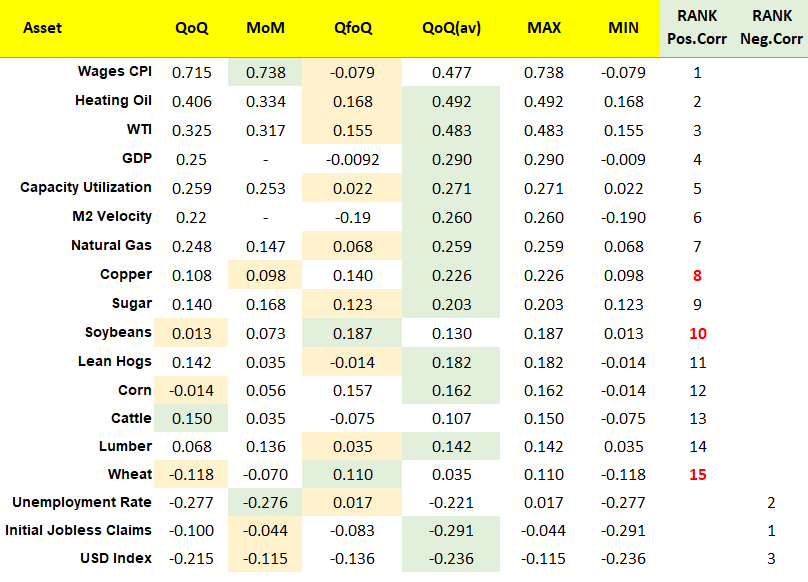

There is some variation between what works best but incorporating a rolling average on the variables played out well with the exception of the below:
   * Wages CPI
   * Soybeans
   * Cattle
   * Wheat
   * Unemployment Rate

Two of the above are also under consideration for removal